# Exploratory Modelling and Analysis of Vensim Cobalt Model

### First, import packages

In [409]:
from __future__ import (absolute_import, print_function, division,  unicode_literals)
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant, Policy, perform_experiments, ema_logging,
                           TimeSeriesOutcome, perform_experiments, save_results, load_results)
from ema_workbench.analysis import (feature_scoring)
from ema_workbench.analysis.pairs_plotting import (pairs_lines, pairs_scatter, pairs_density)
from ema_workbench.connectors.vensim import (VensimModel) #LookupUncertainty, VensimModel, VensimModelStructureInterface)
from ema_workbench.em_framework import CategoricalParameter
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis.plotting import lines, envelopes, kde_over_time, multiple_densities
from ema_workbench.analysis import clusterer, plotting, Density
from ema_workbench.analysis import scenario_discovery_util as sdutil

import numpy as np
import seaborn as sns #; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt

from Figures import plot_lines_with_envelopes
from plotting_util import group_results, filter_scalar_outcomes,make_grid, make_legend
TIME_LABEL = 'Time'
from ema_workbench.analysis.plotting_util import prepare_data, COLOR_LIST, simple_kde, group_density,\
                                                 plot_envelope, simple_density, do_titles,\
                                                 do_ylabels, TIME
import ema_workbench.analysis.plotting_util as plt_util
from ema_workbench.analysis.plotting import group_by_envelopes, single_envelope, plot_lines_with_envelopes
from ema_workbench.analysis.pairs_plotting import pairs_scatter, pairs_density
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import (get_ex_feature_scores,
                                    RuleInductionType)
import ema_workbench.analysis.cart as cart

In [619]:
import importlib
importlib.reload(sdutil)
importlib.reload(cart)

<module 'ema_workbench.analysis.cart' from 'C:\\ProgramData\\Anaconda3_32bits\\lib\\site-packages\\ema_workbench\\analysis\\cart.py'>

In [3]:
import itertools
import copy
from copy import deepcopy

import numpy as np
import datetime
import math
import matplotlib.gridspec as gridspec

import scipy.stats.kde as kde
from matplotlib.colors import ColorConverter
from matplotlib.collections import PolyCollection, PathCollection
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from matplotlib.patches import ConnectionPatch
import matplotlib.font_manager as fm
import matplotlib as mpl

### Set WD

In [4]:
# wd = 'C:/Users/erika/Google Drive/EPA/Thesis/Model/'
wd = 'C:/Users/erika/Desktop/EMA_runs/'
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### Define model

In [7]:
Cobalt_model = VensimModel('Vensim', wd = wd, model_file=wd+'ExplorationCobaltSystem_EvanderLinden.vpm')

### Define uncertainties and outcomes

In [8]:
Cobalt_model.uncertainties = [
#     Switches
        CategoricalParameter('Switch opportunity cost fixed stock',(1,2),pff = True ),
        CategoricalParameter('Switch SSP', (1,2,3,4,5) ),
        CategoricalParameter('Switch carbon policy',(0,1) ),
        CategoricalParameter('Switch energy price growth scenario', (1,2,3) ),
        CategoricalParameter('Switch real price', (1,2)),
#     Assumptions metal stocks
        RealParameter('Percentage lost during artisanal mining',0.4 ,0.6 ),
#         RealParameter('Part artisanal mining from classified reserves',0.1 ,0.3 ),
#         RealParameter('Administration time',10 ,20 ),
#         RealParameter('Average time mining until refining',0.09 ,0.11 ),
#         RealParameter('Average time scrap to recycling',0.38 ,0.42 ),
#         RealParameter('Maximum cobalt recycling efficiency score',0.7 ,0.9 ),
#         RealParameter('Maximum nickel recycling efficiency score',0.9 ,0.99 ),
#         RealParameter('Maximum copper recycling efficiency score',0.95 ,0.999 ),
#         RealParameter('Metal content cobalt scrap',0.003 ,0.006 ),
#         RealParameter('Metal content nickel scrap',0.01 ,0.02 ),
#         RealParameter('Metal content copper scrap',0.01 ,0.02 ),
        RealParameter('Percentage of primary scrap',0.25 ,0.4 ),
        RealParameter('Initial average lifetime of metal in use',5 ,15 ),
        RealParameter('Collection rate metal products',0.4 ,0.8 ),
#         RealParameter('Short forecasting period', 0.5,2 ),
#         CategoricalParameter('Delay order consumption forecast',(1,3,5) ),
#         RealParameter('Minimum usage mining capacity', 0.7,0.9),
        RealParameter('Minimum usage smelting and refining capacity', 0.7,0.9),
#         RealParameter('Percentage lost during operations', 0.04, 0.08),
# #     Assumptions industrial and artisanal mining capacity
        RealParameter('Mining usage investment cap',0 ,0.95 ),
#         CategoricalParameter('Delay order production capacity',(1,3,5) ),
#         RealParameter('Average permit term', 5 , 15 ),
#         RealParameter('Smelter and refiner usage investment cap', 0, 0.95), 
#         RealParameter('Percentage of profit from refined cobalt for artisanal miners', 0.04, 0.1),
        RealParameter('Productivity of artisanal mining', 800, 1600),
#         RealParameter('Minimum cost of artisanal mining', 800, 1300),
        RealParameter('Maximum increase recovery rate', 0.05, 0.25),
# #     Assumptions Demand
#         RealParameter('Ni per dollar GDP', 0.000004, 0.000008 ),
#         RealParameter('Co per dollar GDP', 0.0000001, 0.0000005 ),
#         RealParameter('Cu per dollar GDP', 0.000025, 0.000035 ),
#         RealParameter('Period for long term effect on demand', 5,15),
#         RealParameter('Copper substitution threshold', 3,5),
#         RealParameter('Nickel substitution threshold', 5,9),
#         RealParameter('Cobalt substitution threshold', 5,7),
#         RealParameter('Long term substitution strength',0.1, 0.15),
#         RealParameter('Short term substitution strength', 0.02, 0.06),
#         RealParameter('Substitution strength battery compared to traditional', 0.01,0.05),
# #     Assumptions Battery transition
#         RealParameter('Increase in demand stationary storage', 0.2 , 0.4),
        RealParameter('Slowing of increase in demand stationary storage', 0.88 , 0.96),
#         RealParameter('Battery capacity PHEV', 10 , 30),
        RealParameter('Battery capacity BEV', 30 , 120),
#         RealParameter('Number of cars per dollar GDP', 5e-007, 3e-006),
#         RealParameter('Battery capacity Ebus',150, 220 ),
#         RealParameter('Number of buses per person',0.001, 0.002),
#         RealParameter('Battery capacity Etruck', 70, 150),
# #     Assumptions Economics
#         RealParameter('Percentage cost on top of marginal cost', 0.05 , 0.25 ),
#         RealParameter('Price elasticity long term', 0.1 , 0.25),
#         RealParameter('Price elasticity short term', 0.02, 0.08),
#         RealParameter('Price amplifying factor', 0.5 , 3),
#         RealParameter('Cobalt taxes', 0.4, 2),
#         RealParameter('Nickel taxes', 0.1, 0.5),
#         RealParameter('Copper taxes', 0.05, 0.3),
#         RealParameter('Marginal cost bottom price relationship copper', 0.01, 0.015),
#         RealParameter('Marginal cost bottom price relationship nickel', 0.08, 0.12),
#         RealParameter('Marginal cost bottom price relationship cobalt', 0.05,0.075),
#         RealParameter('Exponent copper price curve',-1.6, -1.4),
#         RealParameter('Exponent nickel price curve',-0.95, -0.85),
#         RealParameter('Exponent cobalt price curve',-1.3, -1.1),
#         RealParameter('Innovation in mining sector', 0.8 ,1 ),
#         RealParameter('Relation ore grade energy usage copper',-1.05,-0.95 ),
#         RealParameter('Relation ore grade energy usage nickel',-0.77, -0.67 ),
#         RealParameter('Relation ore grade energy usage cobalt',-3.1, -2.9 ),
#         RealParameter('Base energy usage copper', 0.075,0.085),
#         RealParameter('Base energy usage nickel', 0.09, 0.13),
#         RealParameter('Base energy usage cobalt', 0.09, 0.11),
#         RealParameter('Transport costs copper', 0.02, 0.06),
#         RealParameter('Transport costs nickel', 0.1, 0.3),
#         RealParameter('Transport costs cobalt', 0.1, 0.3),
#         RealParameter('Price averaging period', 0.1, 0.4),
        RealParameter('Power for oregrades', 0.38, 0.42 ),
#         RealParameter('Maximum increase production capacity', 0.1, 0.2),
#         RealParameter('Maximum decrease production capacity', 0.02, 0.05),
]
    
Cobalt_model.outcomes =  [
#     General
        TimeSeriesOutcome('TIME'),
#         TimeSeriesOutcome('Total demand[Copper]'),
#         TimeSeriesOutcome('Total demand[Nickel]'),
        TimeSeriesOutcome('Total demand[Cobalt]'),
#         TimeSeriesOutcome('Marginal cost[Copper]'),
#         TimeSeriesOutcome('Marginal cost[Nickel]'),
#         TimeSeriesOutcome('Marginal cost[Cobalt]'),
#     Fixed Stock metrics
#         TimeSeriesOutcome('R over P ratio[Copper]'),
#         TimeSeriesOutcome('R over P ratio[Nickel]'),
        TimeSeriesOutcome('R over P ratio[Cobalt]'),
#         TimeSeriesOutcome('Exponential index of depletion[Copper]'),
#         TimeSeriesOutcome('Exponential index of depletion[Nickel]'),
        TimeSeriesOutcome('Exponential index of depletion[Cobalt]'),
#     Opportunity Cost metrics
#         TimeSeriesOutcome('Real price[Copper]'),
#         TimeSeriesOutcome('Real price[Nickel]'),
        TimeSeriesOutcome('Real price[Cobalt]'),
#     Relative parts types of mining
        TimeSeriesOutcome('Relative part artisanal mining[Cobalt]'),
        TimeSeriesOutcome('Artisanal ore trade[Cobalt]'),
#         TimeSeriesOutcome('Industrial Ore mining[Copper]'),
#         TimeSeriesOutcome('Industrial Ore mining[Nickel]'),
        TimeSeriesOutcome('Industrial Ore mining[Cobalt]'),
#         TimeSeriesOutcome('Relative part industrial mining[Copper]'),
#         TimeSeriesOutcome('Relative part industrial mining[Nickel]'),
#         TimeSeriesOutcome('Relative part industrial mining[Cobalt]'),
#         TimeSeriesOutcome('Relative part recycled scrap[Copper]'),
#         TimeSeriesOutcome('Relative part recycled scrap[Nickel]'),
        TimeSeriesOutcome('Relative part recycled scrap[Cobalt]'),
#     Metal stocks
#         TimeSeriesOutcome('Resources[Copper]'),
#         TimeSeriesOutcome('Resources[Nickel]'),
        TimeSeriesOutcome('Resources[Cobalt]'),
#         TimeSeriesOutcome('Reserve base[Copper]'),
#         TimeSeriesOutcome('Reserve base[Nickel]'),
        TimeSeriesOutcome('Reserves[Cobalt]'),
#         TimeSeriesOutcome('Recycling input rate[Copper]'),
#         TimeSeriesOutcome('Recycling input rate[Nickel]'),
        TimeSeriesOutcome('Recycling input rate[Cobalt]'),
#         TimeSeriesOutcome('Recycling efficiency score[Copper]'),
#         TimeSeriesOutcome('Recycling efficiency score[Nickel]'),
        TimeSeriesOutcome('Recycling efficiency score[Cobalt]'),
#         TimeSeriesOutcome('Smelting and refining capacity utilisation rate[Copper]'),
#         TimeSeriesOutcome('Smelting and refining capacity utilisation rate[Nickel]'),
#         TimeSeriesOutcome('Smelting and refining capacity utilisation rate[Cobalt]'),
        TimeSeriesOutcome('Metal recovered from scrap[Cobalt]'),    
# #     Industrial and artisanal mining capacity
        TimeSeriesOutcome('Industrial mining capacity[Sed hosted Co]'),
#         TimeSeriesOutcome('Industrial mining capacity[Sed hosted]'),
        TimeSeriesOutcome('Industrial mining capacity[Ni laterite Co]'),
#         TimeSeriesOutcome('Industrial mining capacity[Ni laterite]'),
#         TimeSeriesOutcome('Industrial mining capacity[Porphyry Cu]'),
        TimeSeriesOutcome('Industrial mining capacity[Magm sulfide Co]'),
#         TimeSeriesOutcome('Industrial mining capacity[Magm sulfide]'),
#         TimeSeriesOutcome('Industrial mining capacity metals[Copper]'),
#         TimeSeriesOutcome('Industrial mining capacity metals[Nickel]'),
        TimeSeriesOutcome('Industrial mining capacity metals[Cobalt]'),
        TimeSeriesOutcome('Cobalt recovery rate[Sed hosted Co]'),
        TimeSeriesOutcome('Cobalt recovery rate[Ni laterite Co]'),
        TimeSeriesOutcome('Cobalt recovery rate[Magm sulfide Co]'),
#         TimeSeriesOutcome('Smelting and refining capacity[Copper]'),
#         TimeSeriesOutcome('Smelting and refining capacity[Nickel]'),
#         TimeSeriesOutcome('Smelting and refining capacity[Cobalt]'),
#         TimeSeriesOutcome('Population Katanga below poverty line'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Cobalt,Sed hosted Co]'),
#         TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Copper,Sed hosted Co]'),
#         TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Nickel,Ni laterite Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Cobalt,Ni laterite Co]'),
#         TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Copper,Magm sulfide Co]'),
#         TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Nickel,Magm sulfide Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Cobalt,Magm sulfide Co]'),
    #     Demand
#         TimeSeriesOutcome('Total substitution[Copper]'),
#         TimeSeriesOutcome('Total substitution[Nickel]'),
#         TimeSeriesOutcome('Total substitution[Cobalt]'),
#         TimeSeriesOutcome('Postponed demand[Copper]'), 
#         TimeSeriesOutcome('Postponed demand[Nickel]'),
#         TimeSeriesOutcome('Postponed demand[Cobalt]'),
# #     Battery transition
#         TimeSeriesOutcome('Total battery capacity demand from cars'),
#         TimeSeriesOutcome('Battery capacity demand from Ebuses'),
#         TimeSeriesOutcome('Battery capacity demand from Etrucks'),
#         TimeSeriesOutcome('New consumer electronics capacity'),
#         TimeSeriesOutcome('Newly built stationary storage capacity'),
# #     Economics
#         TimeSeriesOutcome('Energy price'),
#         TimeSeriesOutcome('Energy costs mining[Copper]'),
#         TimeSeriesOutcome('Energy costs mining[Nickel]'),
#         TimeSeriesOutcome('Energy costs mining[Cobalt]'),
        TimeSeriesOutcome('Energy usage mining[Cobalt]'),
#         TimeSeriesOutcome('Normalised profit forecast[Copper]'),
#         TimeSeriesOutcome('Normalised profit forecast[Nickel]'),
#         TimeSeriesOutcome('Normalised profit forecast[Cobalt]'),
        TimeSeriesOutcome('Marge per lb[Cobalt]'),
# #     SSPs
#         TimeSeriesOutcome('World population'),
#         TimeSeriesOutcome('Population growth'),
#         TimeSeriesOutcome('GDP per capita growth per year'),
#         TimeSeriesOutcome('World GDP growth per year'),
]

## Create, or load results

In [9]:
nr_experiments =1500
results_both_alloutcomes = perform_experiments([Cobalt_model],
                                  nr_experiments, uncertainty_sampling='pff')

[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


In [11]:
save_results(results_both_alloutcomes, r'C:/Users/erika/Desktop/EMA_runs/4000runs_pff3_moreoutcomes.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\erika\Desktop\EMA_runs\4000runs_pff3_moreoutcomes.tar.gz


In [10]:
# results_both_alloutcomes = load_results(r'C:/Users/erika/Desktop/EMA_runs/4000runs_pff3_moreoutcomes.tar.gz')

## Data preparation

In [12]:
exp_b, out_b= results_both_alloutcomes

In [13]:
exp_b['Paradigm switch'] = None

In [14]:
exp_b['Paradigm switch'][exp_b['Switch opportunity cost fixed stock'] == 1] = 'Fixed stock'
exp_b['Paradigm switch'][exp_b['Switch opportunity cost fixed stock'] == 2] = 'Opportunity cost'

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
exp_fs = None
exp_oc = None

In [16]:
out_fs = {}
out_oc = {}
for i in out_b:
    out_fs[i] = out_b[i][:1500]
    out_oc[i] = out_b[i][1500:]
exp_fs = exp_b[:1500]
exp_oc = exp_b[1500:]
results_fs = exp_fs, out_fs
results_oc = exp_oc, out_oc

In [80]:
out_b['Average cobalt recovery rate'] = sum([ out_b['Cobalt recovery rate[Sed hosted Co]'],out_b['Cobalt recovery rate[Ni laterite Co]'],out_b['Cobalt recovery rate[Magm sulfide Co]'] ])/3
out_fs['Average cobalt recovery rate'] = sum([ out_fs['Cobalt recovery rate[Sed hosted Co]'],out_fs['Cobalt recovery rate[Ni laterite Co]'],out_fs['Cobalt recovery rate[Magm sulfide Co]'] ])/3
out_oc['Average cobalt recovery rate'] = sum([ out_oc['Cobalt recovery rate[Sed hosted Co]'],out_oc['Cobalt recovery rate[Ni laterite Co]'],out_oc['Cobalt recovery rate[Magm sulfide Co]'] ])/3

In [18]:
out_b['Percentage profit industrial mining from Cobalt']  = sum([out_b['Percentage profit industrial mining capacity per metal[Cobalt,Sed hosted Co]'],
                                                               out_b['Percentage profit industrial mining capacity per metal[Cobalt,Ni laterite Co]'],
                                                               out_b['Percentage profit industrial mining capacity per metal[Cobalt,Magm sulfide Co]']])/3

## Defining some functions

In [19]:
def clustering (paradigm, column, nr_of_clusters):
    if paradigm == 'fs':
        dataset=out_fs
        expdata=exp_fs
    elif paradigm == 'oc':
        dataset=out_oc
        expdata=exp_oc
    else:
        dataset = out_b
        expdata = exp_b
    data = dataset[column]
    distances = clusterer.calculate_cid(data)

    # calcuate distances
    distances = clusterer.calculate_cid(data)

    # do agglomerative clustering on the distances
    clusters = clusterer.apply_agglomerative_clustering(distances,
                                                    n_clusters=nr_of_clusters)

    # show the clusters in the output space
    x = expdata.copy()
    x['clusters'] = clusters.astype('object')
    return (x)

In [20]:
def plot_clusters (paradigm,column,x, zero = False,ylabel = False):
    if paradigm == 'fs':
        dataset=out_fs
        expdata=exp_fs
    elif paradigm == 'oc':
        dataset=out_oc
        expdata=exp_oc
    else:
        dataset = out_b#smaller_out_b
        expdata = exp_b#smaller_exp_b
    #plot the clusters
    lines(x, dataset,group_by = 'Clusters',outcomes_to_show = column,
                   density=Density.KDE)
    fig = plt.gcf()
    ax = fig.get_axes()
    ax[0].set_xticklabels(labels_time)
    fig.set_size_inches(7,5)
#     plt.yscale('log')
    
    #layout
    plt.margins(0)
    sns.despine()
    
    if zero == True:
        ax[0].set_ylim([0,None])
    ax[0].set_xticklabels(labels_time)
    if ylabel:
        ax[0].set(ylabel=ylabel)
    change_fontsize(fig)
    sns.despine()
#     save_fig(fig,wd,'clustering'+paradigm+column)
    return fig,ax

In [21]:
def plot_one_cluster(paradigm, column, clusternr, x, zero=False):
    if paradigm == 'fs':
        dataset=out_fs
        expdata=exp_fs
    elif paradigm == 'oc':
        dataset=out_oc
        expdata=exp_oc
    else:
        dataset = out_b
        expdata = exp_b
    
    data2 = prepare_data(x,out_oc, outcomes_to_show = column,group_by = 'clusters')
    #plot the clusters
    lines(x, data2[0][clusternr], outcomes_to_show = column,
                   density=Density.KDE)
    fig = plt.gcf()
    ax = fig.get_axes()
    ax[0].set_xticklabels(labels_time)

    fig.set_size_inches(13,7)
    if zero == True:
        ax[0].set_ylim([0,None])
    plt.show()

In [22]:
def clusters_boxplot (paradigm, column_for_boxplot,x):
    fig, ax = plt.subplots(figsize=(15,8))
    plt.suptitle('')
    x.boxplot(column=[column_for_boxplot],by='clusters', ax=ax)

In [23]:
def clusters_pairplotting (x, listwithvariables ):
    # show the input space
    sns.pairplot(x, hue='clusters',
                 vars=listwithvariables)
    fig = plt.gcf()
    fig.set_size_inches(16,16)
    plt.show()

In [24]:
def find_colors(ax):
    color_converter = ColorConverter()
    all_colors = []
    for line in ax.get_lines():
        orig_color = line.get_color()
        if orig_color not in all_colors:
            all_colors.append(orig_color)
    return all_colors

In [25]:
def save_fig(fig, dir, name,
             dpi=300):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.   

    Parameters
    ----------
    fig : a Figure instance
    dir : str
          the directory where figures are to be saved
    name : str
    dpi : int, optional
    '''
    fig.savefig('{}/fig_{}_{}dpi.png'.format(dir, name, dpi), dpi=dpi, 
                bbox_inches='tight', format='png') 


In [26]:
def change_fontsize(fig, fs=11.5):
    '''Change fontsize of figure items to specified size'''
    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)
        try:
            parasites = ax.parasites
        except AttributeError:
            pass
        else:
            for parisite in parasites:
                for axis in parisite.axis.values():
                    axis.major_ticklabels.set_fontsize(fs)
                    axis.label.set_fontsize(fs)
            for axis in ax.axis.values():
                axis.major_ticklabels.set_fontsize(fs)
                axis.label.set_fontsize(fs)
        if ax.legend_ != None:
            for entry in ax.legend_.get_texts():
                entry.set_fontsize(fs)       
        for entry in ax.texts:
            entry.set_fontsize(fs)        
        for entry in ax.tables:
            entry.set_fontsize(fs)

In [27]:
def nice_lines (exp,out,out_to_show,
                group_by= None,
                density=None,title=None,
                exp_to_show = None,
                grouping_specifiers = None,
                legend = False,
                paradigm = '',
                convert_to_t = False,
                convert_to_kt = False,
                convert_to_Mt = False,
                zero = False ,
                yupperlim = None,
                ylabel = False,
                alpha = None,
                sizex = None,
                sizey = None):
    if convert_to_t == True:
        out[title] = out[out_to_show]/2204.622620
        lines(experiments = exp, outcomes = out, 
               experiments_to_show = exp_to_show,
               outcomes_to_show  =  title, legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    elif convert_to_kt == True:
        out[title] = out[out_to_show]/2204622.620
        lines(experiments = exp, outcomes = out, 
              experiments_to_show = exp_to_show,
               outcomes_to_show  =  title,legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    elif convert_to_Mt == True:
        out[title] = out[out_to_show]/2204622620
        lines(experiments = exp, outcomes = out, 
              experiments_to_show = exp_to_show,
               outcomes_to_show  =  title,legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    else:
        out[title] = out[out_to_show]
        lines(experiments = exp, outcomes = out, 
              experiments_to_show = exp_to_show,
               outcomes_to_show  =  title,legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    fig = plt.gcf()
    fig.set_size_inches(6,3)
    if sizex:
        fig.set_size_inches(sizex,sizey)
    ax = fig.get_axes()
    if zero == True:
        ax[0].set_ylim([0,yupperlim])
    ax[0].set_xticklabels(labels_time)
    if ylabel:
        ax[0].set(ylabel=ylabel)
    if alpha:
        for line in ax[0].get_lines():
            line.set_alpha(alpha)
    short_title = title.replace(" ","")
    change_fontsize(fig)
    sns.despine()
    save_fig(fig,wd,paradigm+short_title)
#     fig.savefig(wd+paradigm+short_title+'.jpg')
    plt.show()

In [51]:
labels_time = [2000, 2010, 2020, 2030, 2040, 2050]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['legend.frameon'] = False
# Call each time:
# sns.despine()

<Figure size 432x288 with 0 Axes>

# Visualisation

## Clustering of demand

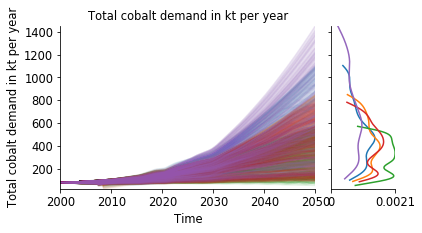

In [29]:
nice_lines(exp_b,out_b,out_to_show = 'Total demand[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Total cobalt demand in kt per year',
           convert_to_kt = True, alpha = 0.05)

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


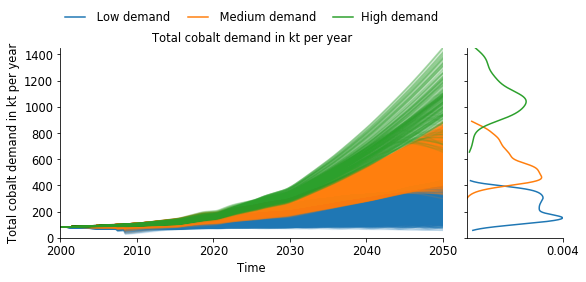

In [31]:
# clustered_demand = clustering('both', 'Total cobalt demand in kt per year',3)
clustered_demand['Clusters']=None
clustered_demand['Clusters'][clustered_demand['clusters'] == 0] = ' Medium demand'
clustered_demand['Clusters'][clustered_demand['clusters'] == 1] = 'High demand'
clustered_demand['Clusters'][clustered_demand['clusters'] == 2] = ' Low demand'
plot_clusters ('both','Total cobalt demand in kt per year',clustered_demand, zero = True)
fig = plt.gcf()
fig.set_size_inches(9,3.5)
save_fig(fig,wd,'demandclustered')
# plt.savefig(wd+'demandclustered')

### Explore most influential variables

In [610]:
def classify(data):
    result = data['Total cobalt demand in kt per year']
    classes = result[:, -1] < 800
    return classes

In [611]:
cart_alg = cart.setup_cart((exp_b, out_b), classify, mass_min = 0.05)

In [612]:
cart_alg.build_tree()

In [617]:
for i in range(len(cart_alg.boxes)):
    cart_alg.boxes[i] = cart_alg.boxes[i].dropna(axis=1)

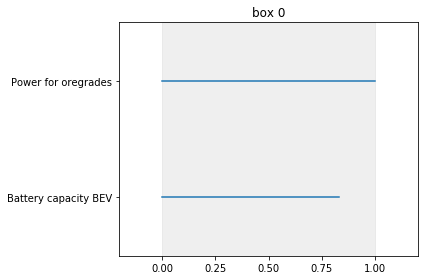

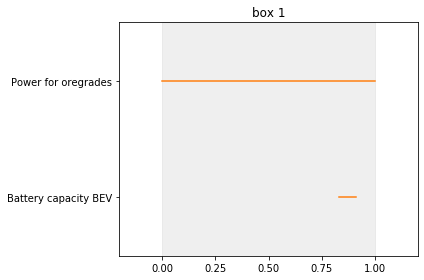

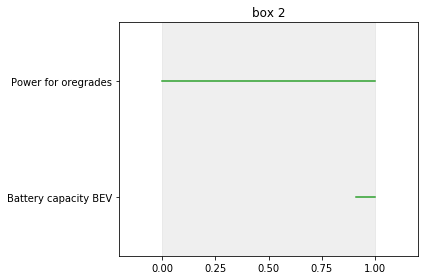

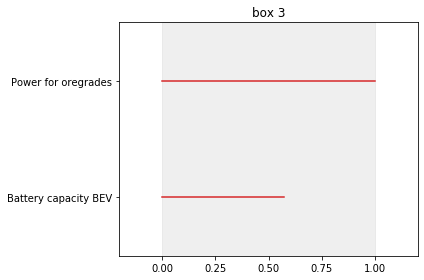

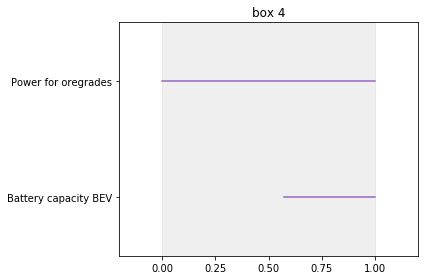

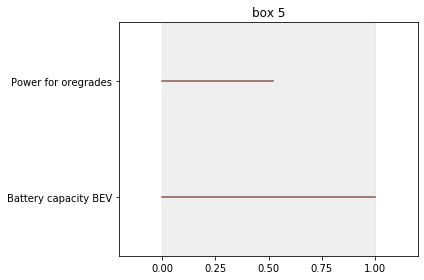

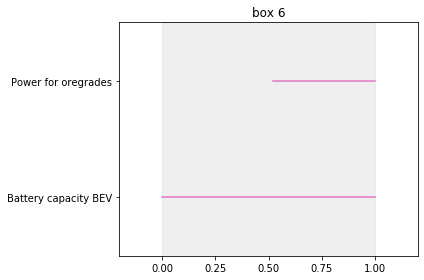

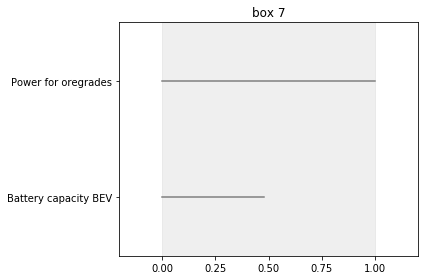

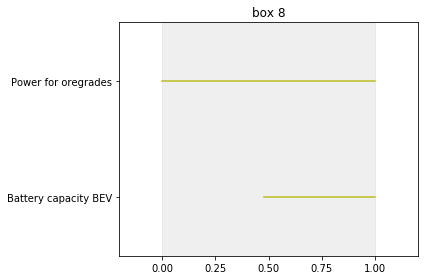

In [576]:
cart_alg.show_boxes(together = False)

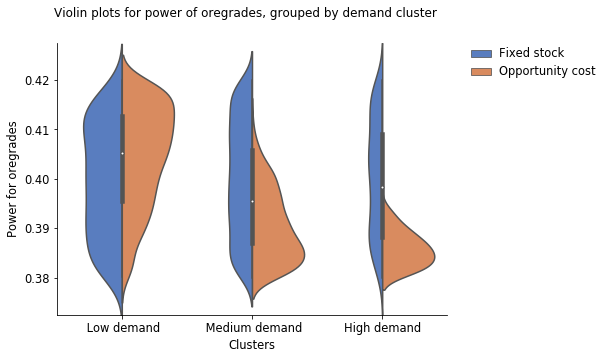

In [32]:
ax = sns.violinplot(x="Clusters", y="Power for oregrades", hue="Paradigm switch",
                     data=clustered_demand, palette="muted", split=True,
                    order = [' Low demand',' Medium demand', 'High demand'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Violin plots for power of oregrades, grouped by demand cluster')
fig = plt.gcf()
fig.set_size_inches(7,5)
sns.despine()
change_fontsize(fig)
save_fig(fig,wd,'violinplot_poweroregrades')
plt.savefig(wd+'Violinplot_poweroregrades')

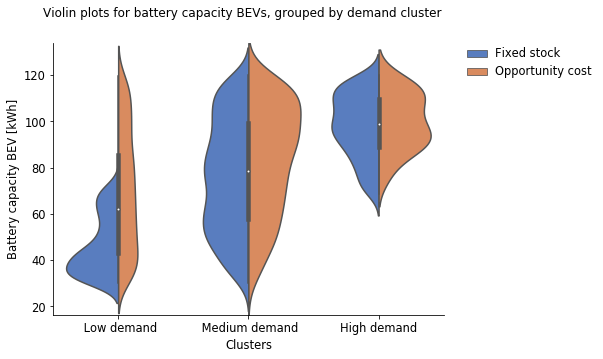

In [33]:
ax = sns.violinplot(x="Clusters", y="Battery capacity BEV", hue="Paradigm switch",
                     data=clustered_demand, palette="muted", split= True,
                    order = [' Low demand',' Medium demand', 'High demand'])
plt.suptitle('Violin plots for battery capacity BEVs, grouped by demand cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = plt.gcf()
plt.ylabel('Battery capacity BEV [kWh]')
fig.set_size_inches(7,5)
sns.despine()
change_fontsize(fig)
save_fig(fig,wd,'violinplot_poweroregrades')
plt.savefig(wd+'Violinplot_batterycapacity')

##  Visualize energy usage mining

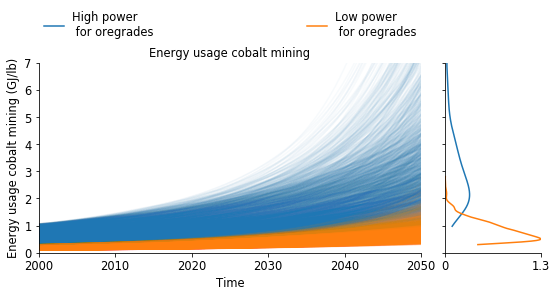

In [223]:
nice_lines(exp_b,out_b, out_to_show = 'Energy usage mining[Cobalt]',
           group_by = 'High power for oregrades', density = Density.KDE, 
           title = 'Energy usage cobalt mining', 
           legend = True, paradigm = 'fs', alpha = 0.03, yupperlim = 7,
           zero = True, ylabel = 'Energy usage cobalt mining (GJ/lb)',
           grouping_specifiers = {'Low power \n for oregrades':0, 'High power \n for oregrades':1},
           sizex = 9, sizey = 3.5)
fig.savefig(wd+'Energyusagemining.jpg')
save_fig(fig,wd,'Energyusagemining')
plt.show()

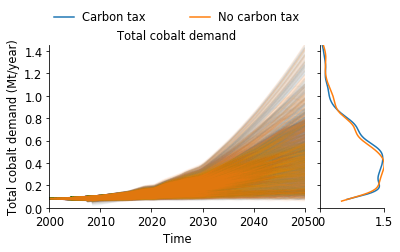

In [224]:
nice_lines(exp_b,out_b,  out_to_show = 'Total demand[Cobalt]',
#            exp_to_show = exp_b[exp_b['Conditions low real price']].index.values,
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon tax':0, 'Carbon tax':1},
           density = Density.KDE, convert_to_Mt = True,
           zero = True, ylabel = 'Total cobalt demand (Mt/year)',
           title = 'Total cobalt demand', alpha = 0.03)

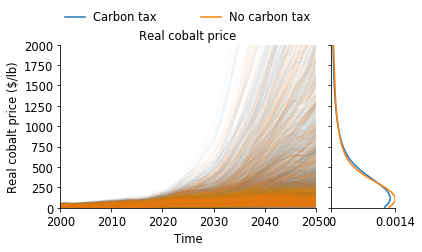

In [225]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon tax':0, 'Carbon tax':1},
           density = Density.KDE, zero = True, yupperlim = 2000,
           title = 'Real cobalt price', ylabel = 'Real cobalt price ($/lb)', alpha = 0.03)

## Visualize influence of energy price growth scenario and oregrade

### Visualize influence of variables on price

In [631]:
exp_b['High energy price'] = exp_b['Switch energy price growth scenario'] <3
exp_fs['High energy price'] = exp_fs['Switch energy price growth scenario'] <3
exp_oc['High energy price'] = exp_oc['Switch energy price growth scenario'] <3

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [632]:
exp_b['High power for oregrades'] = exp_b['Power for oregrades'] >0.4
exp_b['High power for oregrades'] = exp_b['High power for oregrades'].astype('object')
exp_fs['High power for oregrades'] = exp_fs['Power for oregrades'] >0.4
exp_fs['High power for oregrades'] = exp_fs['High power for oregrades'].astype('object')
exp_oc['High power for oregrades'] = exp_oc['Power for oregrades'] >0.4
exp_oc['High power for oregrades'] = exp_oc['High power for oregrades'].astype('object')

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [633]:
exp_b['Conditions high real price'] = exp_b['High energy price'] & exp_b['High power for oregrades']
exp_fs['Conditions high real price'] = exp_fs['High energy price'] & exp_fs['High power for oregrades']
exp_oc['Conditions high real price'] = exp_oc['High energy price'] & exp_oc['High power for oregrades']

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [634]:
exp_b['Conditions high real price'] = exp_b['Conditions high real price'].astype('object')

In [635]:
exp_b['Low energy price'] = exp_b['Switch energy price growth scenario'] ==3
exp_b['Low power for oregrades'] = exp_b['Power for oregrades'] <0.39
exp_b['Conditions low real price'] = exp_b['Low energy price'] & exp_b['Low power for oregrades']

In [636]:
exp_b['Conditions low real price'] = np.invert(exp_b['Conditions high real price'])
exp_fs['Conditions low real price'] = np.invert(exp_fs['Conditions high real price'])
exp_oc['Conditions low real price'] = np.invert(exp_oc['Conditions high real price'])

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


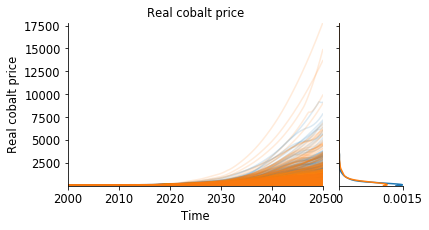

In [626]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           exp_to_show = exp_b['Conditions high real price'].index.values,
           group_by = 'Switch carbon policy', density = Density.KDE, 
          title = 'Real cobalt price')

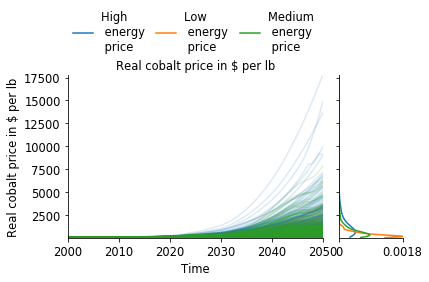

In [627]:
nice_lines(exp_fs,out_fs,out_to_show = 'Real price[Cobalt]',
          group_by = 'Switch energy price growth scenario',
           grouping_specifiers = {'Medium \n energy \n price':2, 'High \n energy \n price':1,'Low \n energy \n price':3},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price in $ per lb')

In [628]:
exp_b['Low power for oregrades'] = np.invert(exp_b['High power for oregrades'])

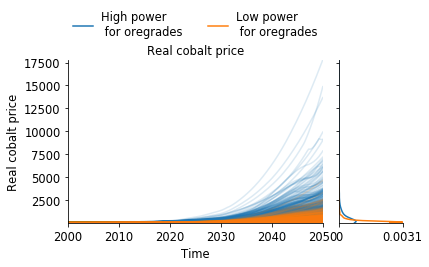

In [629]:
nice_lines(exp_b,out_b,out_to_show = 'Real price[Cobalt]',
          group_by = 'Low power for oregrades',
           grouping_specifiers = {'High power \n for oregrades':-2, 'Low power \n for oregrades':-1},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price')

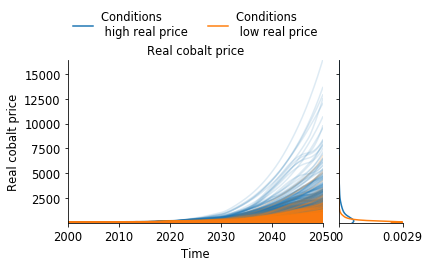

In [219]:
nice_lines(exp_b,out_b,out_to_show = 'Real price[Cobalt]',
          group_by = 'Conditions low real price',
           grouping_specifiers = {'Conditions \n high real price':-2, 'Conditions \n low real price':-1},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price')

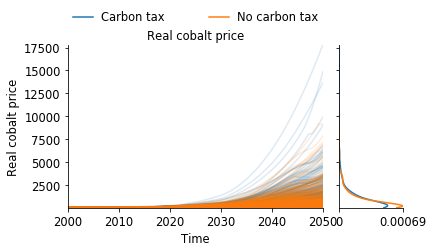

In [638]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           exp_to_show = exp_b[exp_b['Conditions high real price']].index.values,
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon tax':0, 'Carbon tax':1},
           density = Density.KDE, 
           title = 'Real cobalt price')

## Visualize recycling input rate

In [639]:
exp_b['Collection rate cobalt products'] = pd.cut(exp_b['Collection rate metal products'],
                                                  [0.4,0.533,0.666,0.8],
                                                  labels=['40-53%','53-67%','67-80%'])

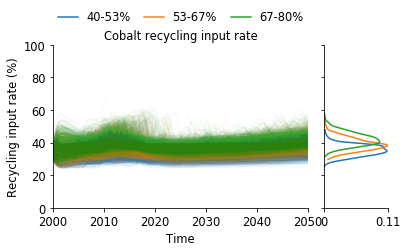

In [640]:
out_b['Recycling input rate cobalt'] = out_b['Recycling input rate[Cobalt]']*100
nice_lines(exp_b,out_b, out_to_show = 'Recycling input rate cobalt',
           group_by = 'Collection rate cobalt products', density = Density.KDE, 
           title = 'Cobalt recycling input rate', 
           legend = True, zero = True, alpha = 0.03,
            yupperlim = 100, ylabel = 'Recycling input rate (%)')
fig.savefig(wd+'cobaltrecyclinginputrate.jpg')
plt.show()

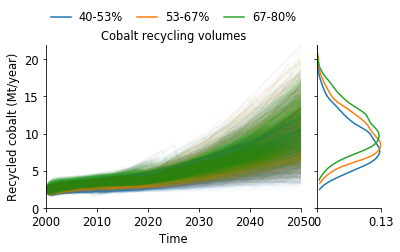

In [231]:
out_b['Recycled cobalt'] = out_b['Metal recovered from scrap[Cobalt]']*100
nice_lines(exp_b,out_b, out_to_show = 'Recycled cobalt',
           group_by = 'Collection rate cobalt products', density = Density.KDE, 
           title = 'Cobalt recycling volumes', 
           legend = True, zero = True, alpha = 0.03, convert_to_Mt = True,
           ylabel = 'Recycled cobalt (Mt/year)')
fig.savefig(wd+'cobaltrecyclingvolumes.jpg')
plt.show()

## Visualize profit industrial mining

In [257]:
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01

[Text(0, 0.5, '100'),
 Text(0, 5.5, '95'),
 Text(0, 10.5, '90'),
 Text(0, 15.5, '85'),
 Text(0, 20.5, '80'),
 Text(0, 25.5, '75'),
 Text(0, 30.5, '70'),
 Text(0, 35.5, '65'),
 Text(0, 40.5, '60'),
 Text(0, 45.5, '55'),
 Text(0, 50.5, '50'),
 Text(0, 55.5, '45'),
 Text(0, 60.5, '40'),
 Text(0, 65.5, '35'),
 Text(0, 70.5, '30'),
 Text(0, 75.5, '25'),
 Text(0, 80.5, '20'),
 Text(0, 85.5, '15'),
 Text(0, 90.5, '10'),
 Text(0, 95.5, '5')]

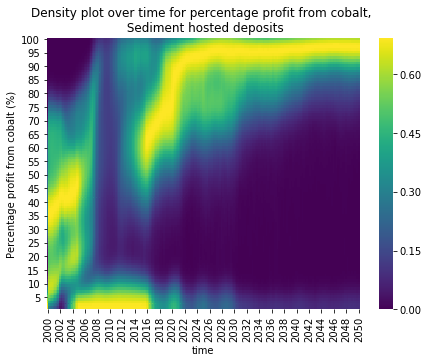

In [129]:
kde_over_time(exp_b,out_b,
              outcomes_to_show = 'Percentage profit from cobalt, Sediment hosted deposit')
plt.title('Density plot over time for percentage profit from cobalt, \n Sediment hosted deposits')
fig = plt.gcf()
fig.set_size_inches(7,5)
ax = fig.get_axes()
ax[0].set_xticklabels(np.arange(2000, 2051, 2))
ax[0].set_ylabel('Percentage profit from cobalt (%)')
ax[0].set_yticklabels(100-np.arange(0, 100, 5))

[Text(0, 0.5, '100'),
 Text(0, 5.5, '95'),
 Text(0, 10.5, '90'),
 Text(0, 15.5, '85'),
 Text(0, 20.5, '80'),
 Text(0, 25.5, '75'),
 Text(0, 30.5, '70'),
 Text(0, 35.5, '65'),
 Text(0, 40.5, '60'),
 Text(0, 45.5, '55'),
 Text(0, 50.5, '50'),
 Text(0, 55.5, '45'),
 Text(0, 60.5, '40'),
 Text(0, 65.5, '35'),
 Text(0, 70.5, '30'),
 Text(0, 75.5, '25'),
 Text(0, 80.5, '20'),
 Text(0, 85.5, '15'),
 Text(0, 90.5, '10'),
 Text(0, 95.5, '5')]

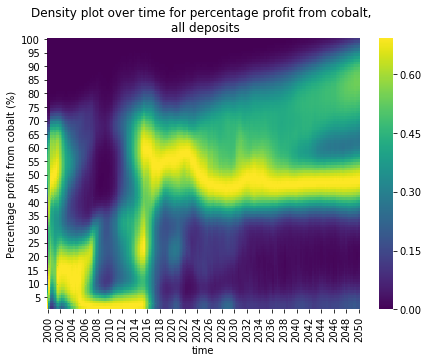

In [130]:
kde_over_time(exp_b,out_b,
              outcomes_to_show = 'Percentage profit industrial mining from Cobalt')
plt.title('Density plot over time for percentage profit from cobalt, \n all deposits')
fig = plt.gcf()
fig.set_size_inches(7,5)
ax = fig.get_axes()
ax[0].set_xticklabels(np.arange(2000, 2051, 2))
ax[0].set_ylabel('Percentage profit from cobalt (%)')
ax[0].set_yticklabels(100-np.arange(0, 100, 5))

## Visualize influence of paradigm on key supply and demand variables

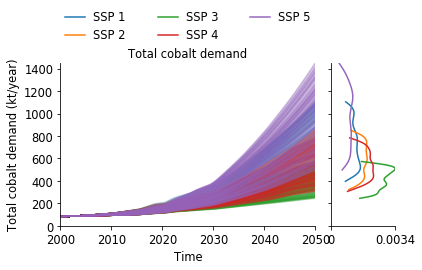

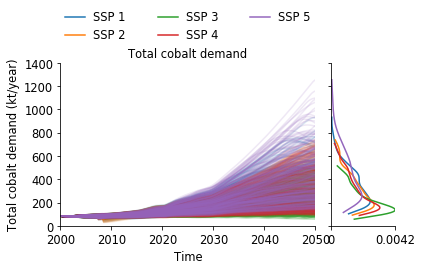

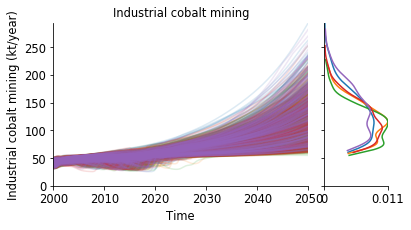

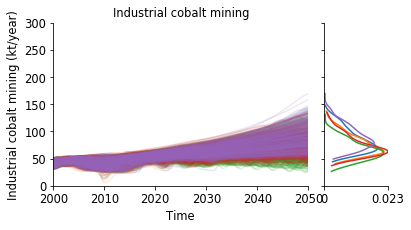

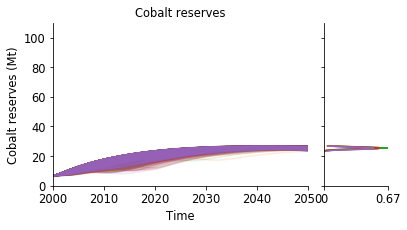

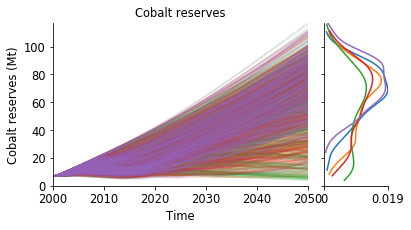

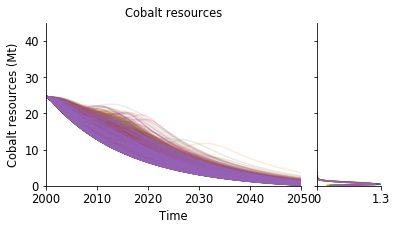

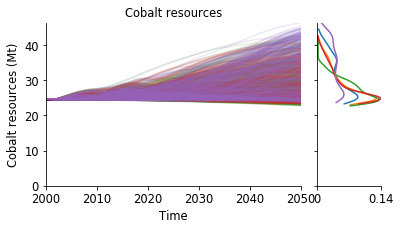

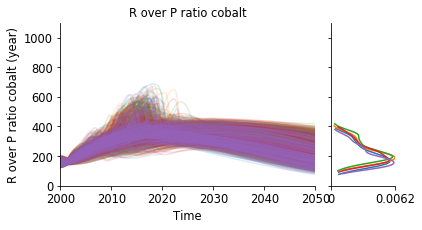

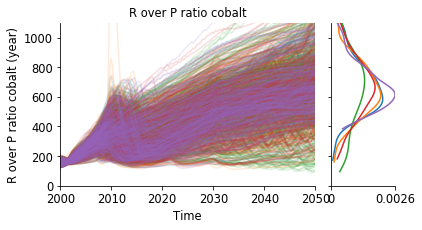

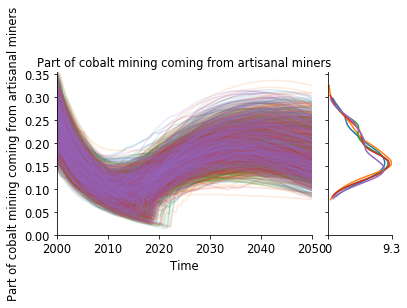

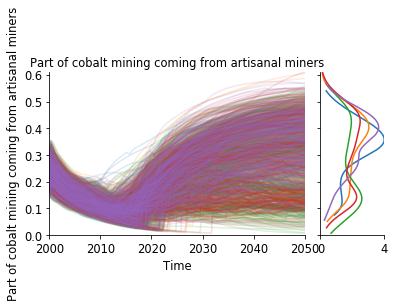

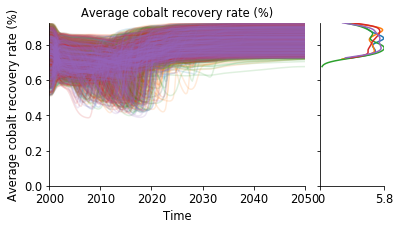

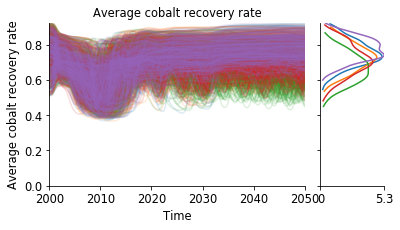

In [625]:
nice_lines(exp_fs,out_fs, out_to_show = 'Total demand[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
           title = 'Total cobalt demand', 
           legend = True, paradigm = 'fs',
           convert_to_kt = True, zero = True, ylabel = 'Total cobalt demand (kt/year)',
           grouping_specifiers = {'SSP 1': 1 , 'SSP 2': 2 ,'SSP 3': 3 ,'SSP 4': 4 ,'SSP 5': 5 })
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'Total demand[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Total cobalt demand', legend = True, ylabel = 'Total cobalt demand (kt/year)',
           convert_to_kt = True, zero = True, yupperlim = 1400,
          grouping_specifiers = {'SSP 1': 1 , 'SSP 2': 2 ,'SSP 3': 3 ,'SSP 4': 4 ,'SSP 5': 5 })

nice_lines(exp_fs,out_fs, out_to_show = 'Industrial Ore mining[Cobalt]',
           group_by = 'Switch SSP', paradigm ='fs', density = Density.KDE, zero = True,
           title = 'Industrial cobalt mining',convert_to_kt = True, 
           ylabel = 'Industrial cobalt mining (kt/year)',)
nice_lines(exp_oc,out_oc,  paradigm ='oc',out_to_show = 'Industrial Ore mining[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True, yupperlim = 300,
           title = 'Industrial cobalt mining',convert_to_kt = True,
           ylabel = 'Industrial cobalt mining (kt/year)')

nice_lines(exp_fs,out_fs, paradigm = 'fs',out_to_show = 'Reserves[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True, yupperlim = 110,
          title = 'Cobalt reserves',convert_to_Mt = True,
          ylabel = 'Cobalt reserves (Mt)')
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'Reserves[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True,
          title = 'Cobalt reserves',convert_to_Mt = True,
          ylabel = 'Cobalt reserves (Mt)')

nice_lines(exp_fs,out_fs,  paradigm ='fs',out_to_show = 'Resources[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True, yupperlim = 45,
          title = 'Cobalt resources',convert_to_Mt = True, ylabel = 'Cobalt resources (Mt)')
nice_lines(exp_oc,out_oc,  paradigm ='oc',out_to_show = 'Resources[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True,
          title = 'Cobalt resources',convert_to_Mt = True, ylabel = 'Cobalt resources (Mt)')

nice_lines(exp_fs,out_fs, paradigm = 'fs',out_to_show = 'R over P ratio[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True, yupperlim = 1100,
          title = 'R over P ratio cobalt', ylabel = 'R over P ratio cobalt (year)')
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'R over P ratio[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True, yupperlim = 1100,
          title = 'R over P ratio cobalt',  ylabel = 'R over P ratio cobalt (year)')

nice_lines(exp_fs,out_fs,  paradigm ='fs',out_to_show = 'Relative part artisanal mining[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True,
          title = 'Part of cobalt mining coming from artisanal miners')
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'Relative part artisanal mining[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, zero = True,
          title = 'Part of cobalt mining coming from artisanal miners')

nice_lines(exp_fs,out_fs, paradigm = 'fs',out_to_show = 'Average Co recovery rate',
           group_by = 'Switch SSP', density = Density.KDE, zero = True,
          title = 'Average cobalt recovery rate (%)')
nice_lines(exp_oc,out_oc,  paradigm ='oc',out_to_show = 'Average Co recovery rate',
           group_by = 'Switch SSP', density = Density.KDE, zero = True,
          title = 'Average cobalt recovery rate')

##  Visualize swing factors in production

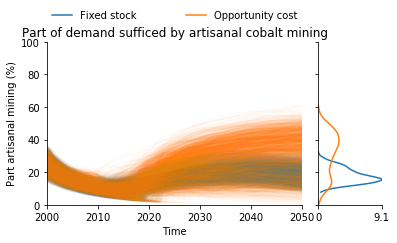

In [123]:
out_b['Part of demand sufficed by artisanal cobalt mining'] = out_b['Relative part artisanal mining[Cobalt]']
lines(exp_b,out_b,outcomes_to_show = 'Part of demand sufficed by artisanal cobalt mining', 
     group_by = 'Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.suptitle('Part of demand sufficed by \n artisanal cobalt mining')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_yticklabels(np.arange(0,101,20))
ax[0].set_ylabel('Part artisanal mining (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.035)
ax[0].set_ylim([0,1])
sns.despine()
save_fig(fig, wd, 'co_relativpartartisanal_paradigm')
plt.show()

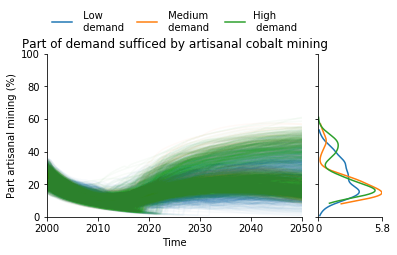

In [135]:
lines(clustered_demand,out_b,outcomes_to_show = 'Part of demand sufficed by artisanal cobalt mining', 
     group_by = 'clusters',
      grouping_specifiers = {'High \n demand':0,' Medium \n demand':1, ' Low \n demand':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.suptitle('Part of demand sufficed by artisanal cobalt mining')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_yticklabels(np.arange(0,101,20))
ax[0].set_ylabel('Part artisanal mining (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.03)
ax[0].set_ylim([0,1])
sns.despine()
save_fig(fig, wd, 'co_relativpartartisanal_demand')
plt.show()

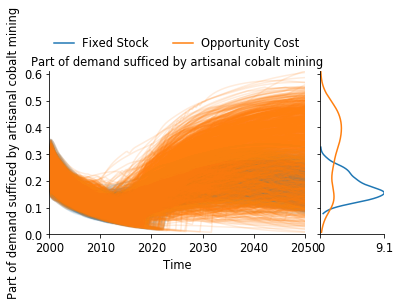

In [117]:
nice_lines(exp_b,out_b,  paradigm ='both',out_to_show = 'Relative part artisanal mining[Cobalt]',
           group_by = 'Switch opportunity cost fixed stock', density = Density.KDE, 
          title = 'Part of demand sufficed by artisanal cobalt mining', legend = True,
          grouping_specifiers = {'Fixed Stock':1, 'Opportunity Cost':2}, zero = True )

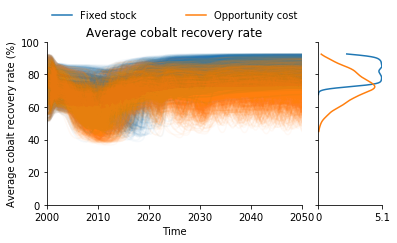

In [97]:
lines(exp_b,out_b,outcomes_to_show = 'Average cobalt recovery rate', 
     group_by = 'Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.suptitle('Percentage industrial cobalt mining \n from Sediment hosted deposits')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_yticklabels(np.arange(0,101,20))
ax[0].set_ylabel('Average cobalt recovery rate (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
ax[0].set_ylim([0,1])
sns.despine()
save_fig(fig, wd, 'co_recovrate_paradigm')
plt.show()

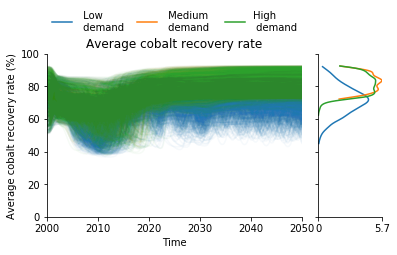

In [95]:
lines(clustered_demand,out_b,outcomes_to_show = 'Average cobalt recovery rate', 
     group_by = 'clusters',
      grouping_specifiers = {'High \n demand':0,' Medium \n demand':1, ' Low \n demand':2},
      density = Density.KDE)
fig = plt.gcf()
# plt.suptitle('Percentage industrial cobalt mining \n from Sediment hosted deposits')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_yticklabels(np.arange(0,101,20))
ax[0].set_ylabel('Average cobalt recovery rate (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
ax[0].set_ylim([0,1])
sns.despine()
save_fig(fig, wd, 'co_recovrate_demand')
plt.show()

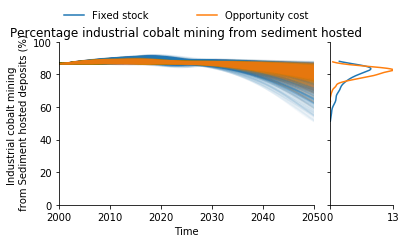

In [94]:
lines(exp_b,out_b,outcomes_to_show = 'Percentage industrial cobalt mining from sediment hosted', 
     group_by = 'Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# plt.suptitle('Percentage industrial cobalt mining \n from Sediment hosted deposits')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,1])
ax[0].set_yticklabels(np.arange(0,101,20))
ax[0].set_ylabel('Industrial cobalt mining \n from Sediment hosted deposits (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
sns.despine()
save_fig(fig, wd, 'perc_sedhost_paradigm')
plt.show()

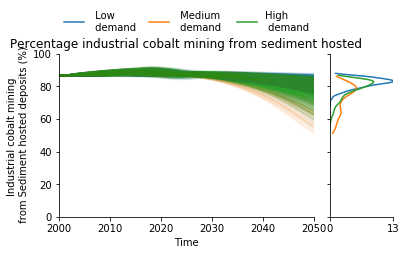

In [96]:
lines(clustered_demand,out_b,outcomes_to_show = 'Percentage industrial cobalt mining from sediment hosted', 
     group_by = 'clusters',
      grouping_specifiers = {'High \n demand':0,' Medium \n demand':1, ' Low \n demand':2},
      density = Density.KDE)
fig = plt.gcf()
# plt.suptitle('Percentage industrial cobalt mining \n from Sediment hosted deposits')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,1])
ax[0].set_yticklabels(np.arange(0,101,20))
ax[0].set_ylabel('Industrial cobalt mining \n from Sediment hosted deposits (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
sns.despine()
save_fig(fig, wd, 'perc_sedhost_demand')
plt.show()

## Visualize cobalt price

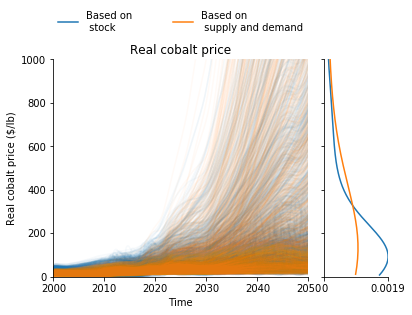

In [261]:
out_b['Real cobalt price'] = out_b['Real price[Cobalt]']
lines(exp_b, out_b, outcomes_to_show = 'Real cobalt price',
      group_by='Switch real price',
      grouping_specifiers = {'Based on \n stock':1, 'Based on \n supply and demand':2},
      density = Density.KDE)
fig = plt.gcf()
fig.set_size_inches(6,4)
# plt.yscale('log')
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,1000])
ax[0].set_ylabel('Real cobalt price ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.035)
sns.despine()
save_fig(fig,wd,'cobaltprice_switchformula')
plt.show()

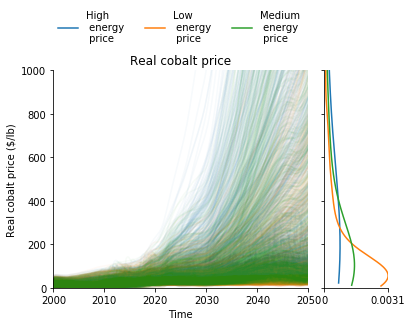

In [262]:
lines(exp_b, out_b, outcomes_to_show = 'Real cobalt price',
      group_by = 'Switch energy price growth scenario',
      grouping_specifiers = {'Medium \n energy \n price':2, 'High \n energy \n price':1,'Low \n energy \n price':3},
      density = Density.KDE)
fig = plt.gcf()
fig.set_size_inches(6,4)
# plt.yscale('log')
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,1000])
ax[0].set_ylabel('Real cobalt price ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.035)
sns.despine()
save_fig(fig,wd,'cobaltprice_switchenergyprice')
plt.show()

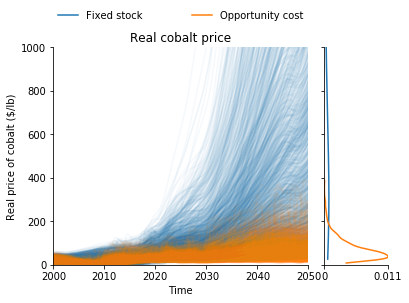

In [263]:
lines(exp_b,out_b, outcomes_to_show = 'Real cobalt price',
      group_by='Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,1000])
ax[0].set_ylabel('Real price of cobalt ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
sns.despine()
save_fig(fig,wd,'cobaltprice_paradigm')
plt.show()

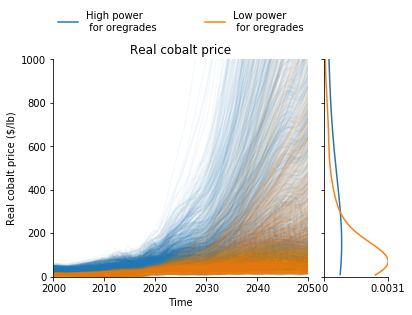

In [331]:
lines(exp_b, out_b, outcomes_to_show = 'Real cobalt price',
      group_by = 'High power for oregrades',
      grouping_specifiers = {'High power \n for oregrades ': 1,'Low power \n for oregrades':0},
      density = Density.KDE)
fig = plt.gcf()
fig.set_size_inches(6,4)
# plt.yscale('log')
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,1000])
for line in ax[0].get_lines():
    line.set_alpha(0.035)
ax[0].set_ylabel('Real cobalt price ($/lb)')
save_fig(fig,wd,'cobaltprice_oregrade')
sns.despine()
plt.show()

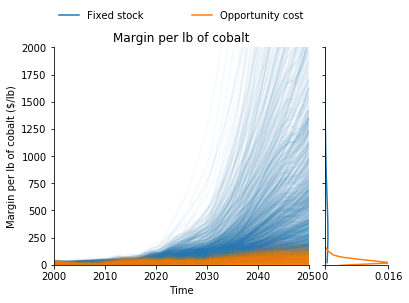

In [256]:
out_b['Margin per lb of cobalt'] = out_b['Marge per lb[Cobalt]']
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt',
      group_by='Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylim([0,2000])
ax[0].set_ylabel('Margin per lb of cobalt ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
sns.despine()
save_fig(fig,wd,'marginperlb_paradigm')
plt.show()

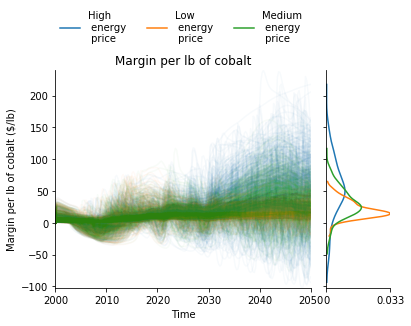

In [249]:
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt', 
      experiments_to_show = exp_b[exp_b['Switch opportunity cost fixed stock']==2].index.values,
      group_by='Switch energy price growth scenario',
      grouping_specifiers = {'High \n energy \n price': 1,'Medium \n energy \n price':2,'Low \n energy \n price':3},
      density = Density.KDE)
fig = plt.gcf()
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylabel('Margin per lb of cobalt ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.03)
sns.despine()
save_fig(fig,wd,'marginperlb_energy')
plt.show()

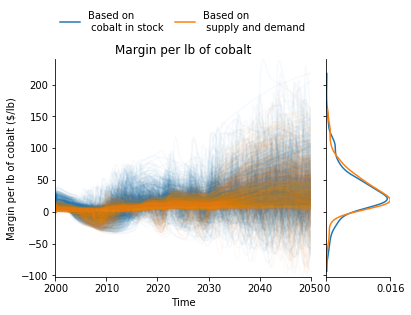

In [250]:
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt', 
      experiments_to_show = exp_b[exp_b['Switch opportunity cost fixed stock']==2].index.values,
      group_by='Switch real price', #energy price growth scenario',
      grouping_specifiers = {'Based on \n cobalt in stock': 1,'Based on \n supply and demand':2,},
      density = Density.KDE)
fig = plt.gcf()
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylabel('Margin per lb of cobalt ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.03)
sns.despine()
save_fig(fig,wd,'marginperlb_priceformula')
plt.show()

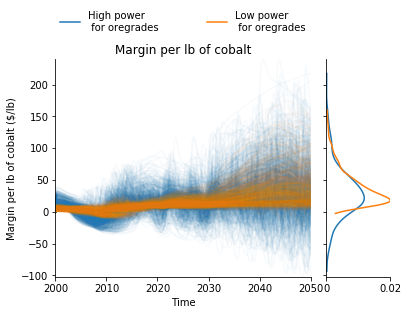

In [251]:
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt', 
      experiments_to_show = exp_b[exp_b['Switch opportunity cost fixed stock']==2].index.values,
      group_by='High power for oregrades', #energy price growth scenario',
      grouping_specifiers = {'High power \n for oregrades ': 1,'Low power \n for oregrades':0},
      density = Density.KDE)
fig = plt.gcf()
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylabel('Margin per lb of cobalt ($/lb)')
for line in ax[0].get_lines():
    line.set_alpha(0.03)
sns.despine()
save_fig(fig,wd,'marginperlb_oregrade')
plt.show()

## Visualize individual runs

In [643]:
# clustered_demand[clustered_demand['Paradigm switch'] == 'Fixed stock'][clustered_demand['clusters']==1][clustered_demand['Power for oregrades']>0.41][clustered_demand['Battery capacity BEV']>90][clustered_demand['Switch energy price growth scenario']==3]

In [644]:
# clustered_demand[clustered_demand['Paradigm switch'] == 'Fixed stock'][clustered_demand['clusters']==2][clustered_demand['Power for oregrades']<0.39][clustered_demand['Battery capacity BEV']<60][clustered_demand['Switch energy price growth scenario']==1]

In [289]:
row1 = exp_b.index.values == 19
row2 = exp_b.index.values == 1519
row3 = exp_b.index.values == 12
row2 = exp_b.index.values == 1512

In [291]:
duh = np.array(np.array([row1 | row2],dtype='int'),dtype= 'object')

In [313]:
exp_b['dugh'] = 0

In [314]:
exp_b['dugh'][19] = 1 
exp_b['dugh'][1519] = 2
exp_b['dugh'][12] = 3
exp_b['dugh'][1512] = 4

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports unti

In [315]:
sum(exp_b['dugh'])

10

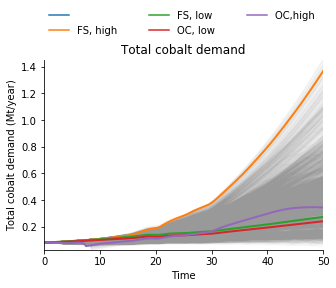

In [327]:
out_b['Total cobalt demand'] = out_b['Total demand[Cobalt]']/2204622620
lines(exp_b, out_b, 'Total cobalt demand',group_by = 'dugh' , legend = True ,
      grouping_specifiers= {'FS, high': 1, 'OC,high ':2, '':0, 'FS, low': 3, 'OC, low':4} )
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(5,3.5)
find_colors(ax[0])
for line in ax[0].get_lines():
    if line.get_color() == (0.12156862745098039, 0.4666666666666667, 0.7058823529411765):
        line.set_color((0.6,0.6,0.6))
        line.set_alpha(0.03)
    if line.get_color() == (1.0, 0.4980392156862745, 0.054901960784313725):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.17254901960784313, 0.6274509803921569, 0.17254901960784313):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.8392156862745098, 0.15294117647058825, 0.1568627450980392):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.5803921568627451, 0.403921568627451, 0.7411764705882353):
        line.set_alpha(1)
        line.set_linewidth(2)
ax[0].set_ylabel('Total cobalt demand (Mt/year)')
sns.despine()
save_fig(fig,wd,'specificruns_demand')

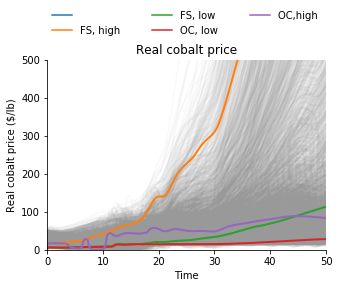

In [328]:
out_b['Real cobalt price'] = out_b['Real price[Cobalt]']
lines(exp_b, out_b, 'Real cobalt price',group_by = 'dugh' , legend = True,
      grouping_specifiers= {'FS, high': 1, 'OC,high ':2, '':0, 'FS, low': 3, 'OC, low':4}  )
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(5,3.5)
find_colors(ax[0])
for line in ax[0].get_lines():
    if line.get_color() == (0.12156862745098039, 0.4666666666666667, 0.7058823529411765):
        line.set_color((0.6,0.6,0.6))
        line.set_alpha(0.05)
    if line.get_color() == (1.0, 0.4980392156862745, 0.054901960784313725):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.17254901960784313, 0.6274509803921569, 0.17254901960784313):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.8392156862745098, 0.15294117647058825, 0.1568627450980392):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.5803921568627451, 0.403921568627451, 0.7411764705882353):
        line.set_alpha(1)
        line.set_linewidth(2)
ax[0].set_ylim([0,500])
ax[0].set_ylabel('Real cobalt price ($/lb)')
sns.despine()
save_fig(fig,wd,'specificruns_price')

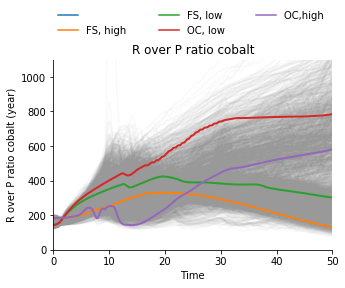

In [329]:
out_b['R over P ratio cobalt'] = out_b['R over P ratio[Cobalt]']
lines(exp_b, out_b, 'R over P ratio cobalt',group_by = 'dugh' , legend = True,
      grouping_specifiers= {'FS, high': 1, 'OC,high ':2, '':0, 'FS, low': 3, 'OC, low':4}  )
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(5,3.5)
find_colors(ax[0])
for line in ax[0].get_lines():
    if line.get_color() == (0.12156862745098039, 0.4666666666666667, 0.7058823529411765):
        line.set_color((0.6,0.6,0.6))
        line.set_alpha(0.05)
    if line.get_color() == (1.0, 0.4980392156862745, 0.054901960784313725):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.17254901960784313, 0.6274509803921569, 0.17254901960784313):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.8392156862745098, 0.15294117647058825, 0.1568627450980392):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.5803921568627451, 0.403921568627451, 0.7411764705882353):
        line.set_alpha(1)
        line.set_linewidth(2)
ax[0].set_ylim([0,1100])
ax[0].set_ylabel('R over P ratio cobalt (year)')
sns.despine()
save_fig(fig,wd,'specificruns_roverp')

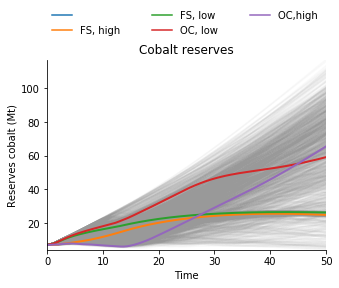

In [330]:
out_b['Cobalt reserves'] = out_b['Reserves[Cobalt]']/2204622620
lines(exp_b, out_b, 'Cobalt reserves',group_by = 'dugh' ,  legend = True,
      grouping_specifiers= {'FS, high': 1, 'OC,high ':2, '':0, 'FS, low': 3, 'OC, low':4}  )
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(5,3.5)
find_colors(ax[0])
for line in ax[0].get_lines():
    if line.get_color() == (0.12156862745098039, 0.4666666666666667, 0.7058823529411765):
        line.set_color((0.6,0.6,0.6))
        line.set_alpha(0.05)
    if line.get_color() == (1.0, 0.4980392156862745, 0.054901960784313725):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.17254901960784313, 0.6274509803921569, 0.17254901960784313):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.8392156862745098, 0.15294117647058825, 0.1568627450980392):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.5803921568627451, 0.403921568627451, 0.7411764705882353):
        line.set_alpha(1)
        line.set_linewidth(2)
ax[0].set_ylabel('Reserves cobalt (Mt)')
sns.despine()
save_fig(fig,wd,'specificruns_reserves')

### Visualize difference R over P ratio and exponential R over P ratio

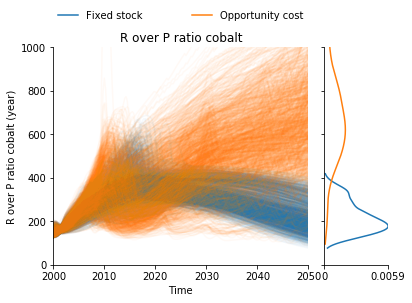

In [325]:
lines(exp_b,out_b, outcomes_to_show = 'R over P ratio cobalt',
      group_by='Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylabel('R over P ratio cobalt (year)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
ax[0].set_ylim([0,1000])
sns.despine()
save_fig(fig,wd,'roverpratio_paradigm')
plt.show()

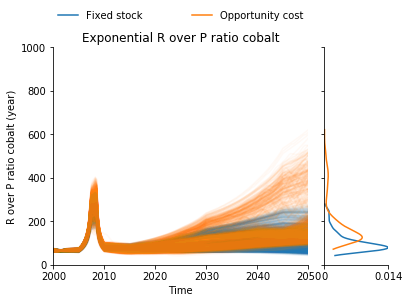

In [326]:
out_b['Exponential R over P ratio cobalt'] = out_b['Exponential index of depletion[Cobalt]']

lines(exp_b,out_b, outcomes_to_show = 'Exponential R over P ratio cobalt',
      group_by='Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_ylabel('R over P ratio cobalt (year)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
ax[0].set_ylim([0,1000])
sns.despine()
save_fig(fig,wd,'roverpratio_paradigm')
plt.show()

## Visualize cobalt mining capacity % sediment hosted

In [34]:
out_b['Indstrial mining capacity cobalt, sediment hosted (Mt/year)'] = out_b['Industrial mining capacity[Sed hosted Co]']/2204622620 * 0.054
out_b['Indstrial mining capacity cobalt, Ni laterite (Mt/year)'] = out_b['Industrial mining capacity[Ni laterite Co]']/2204622620 * 0.0482
out_b['Indstrial mining capacity cobalt, Magmatic sulfide (Mt/year)'] = out_b['Industrial mining capacity[Magm sulfide Co]']/2204622620 * 0.0061

out_b['Percentage industrial cobalt mining from sediment hosted'] = out_b['Indstrial mining capacity cobalt, sediment hosted (Mt/year)'] / (out_b['Indstrial mining capacity cobalt, sediment hosted (Mt/year)'] + out_b['Indstrial mining capacity cobalt, Ni laterite (Mt/year)'] + out_b['Indstrial mining capacity cobalt, Magmatic sulfide (Mt/year)'])




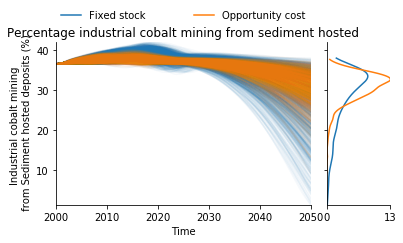

In [77]:
lines(exp_b,out_b,outcomes_to_show = 'Percentage industrial cobalt mining from sediment hosted', 
     group_by = 'Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# plt.suptitle('Percentage industrial cobalt mining \n from Sediment hosted deposits')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_yticklabels(np.arange(0,100,10))
ax[0].set_ylabel('Industrial cobalt mining \n from Sediment hosted deposits (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
sns.despine()
save_fig(fig, wd, 'perc_sedhost_paradigm')
plt.show()

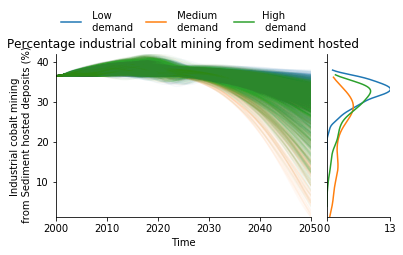

In [76]:
lines(clustered_demand,out_b,outcomes_to_show = 'Percentage industrial cobalt mining from sediment hosted', 
     group_by = 'clusters',
      grouping_specifiers = {'High \n demand':0,' Medium \n demand':1, ' Low \n demand':2},
      density = Density.KDE)
fig = plt.gcf()
# plt.suptitle('Percentage industrial cobalt mining \n from Sediment hosted deposits')
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
ax[0].set_yticklabels(np.arange(0,100,10))
ax[0].set_ylabel('Industrial cobalt mining \n from Sediment hosted deposits (%)')
for line in ax[0].get_lines():
    line.set_alpha(0.04)
sns.despine()
save_fig(fig, wd, 'perc_sedhost_demand')
plt.show()

## Graph dump

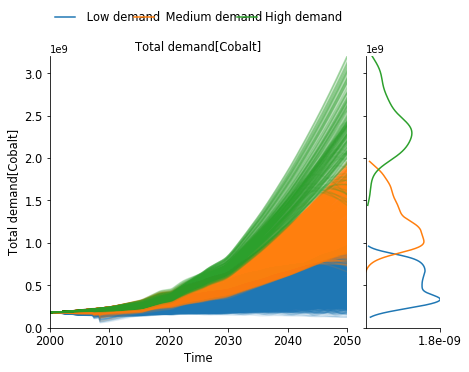

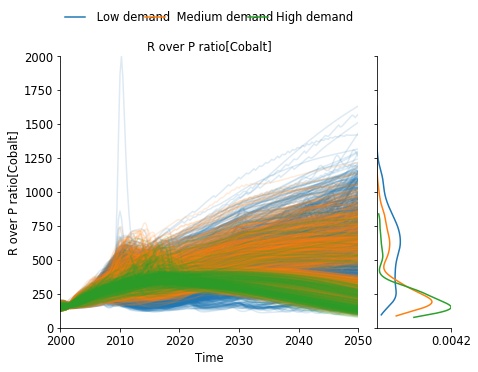

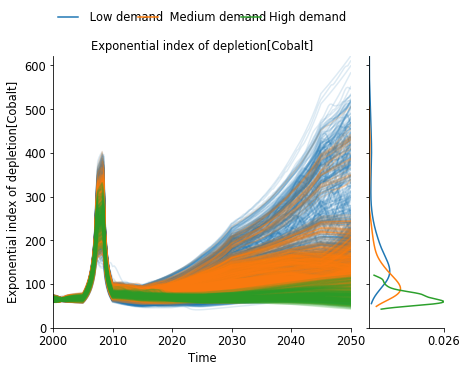

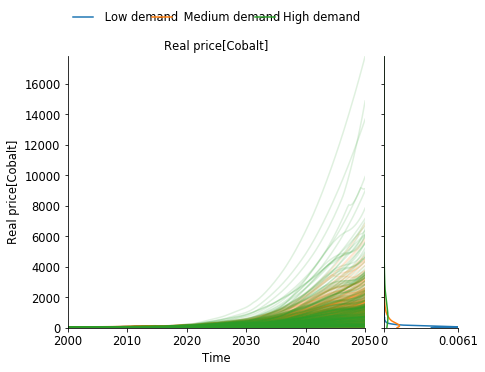

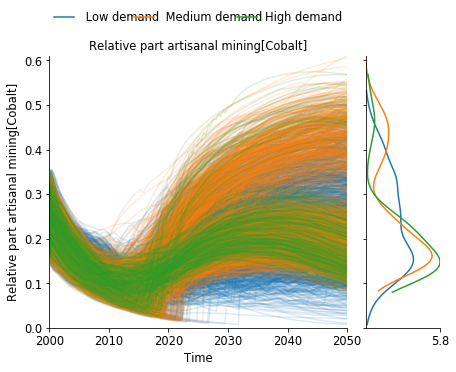

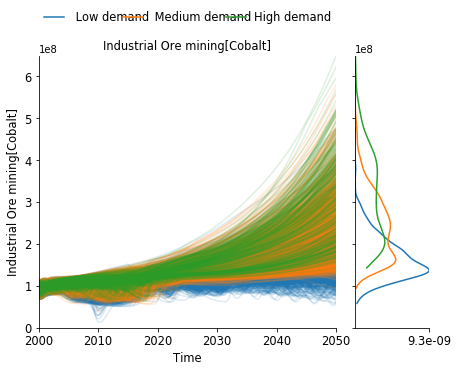

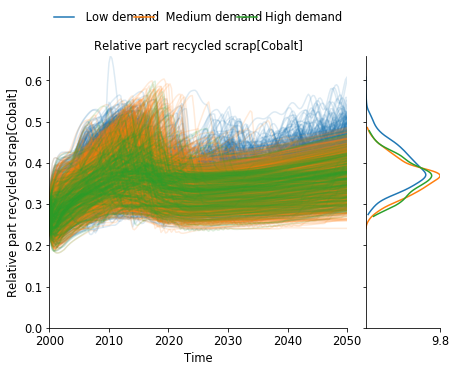

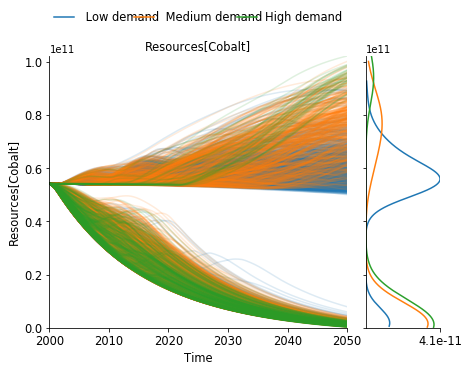

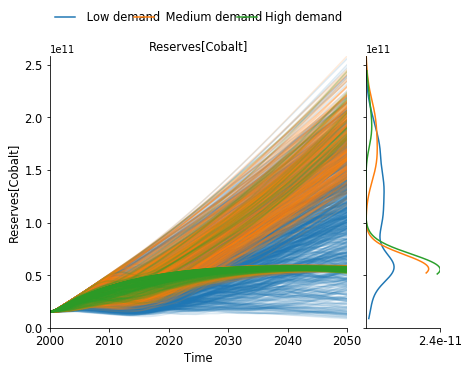

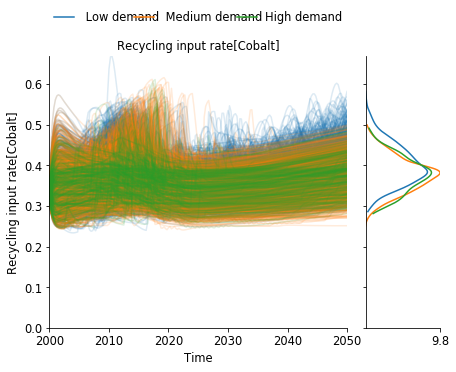

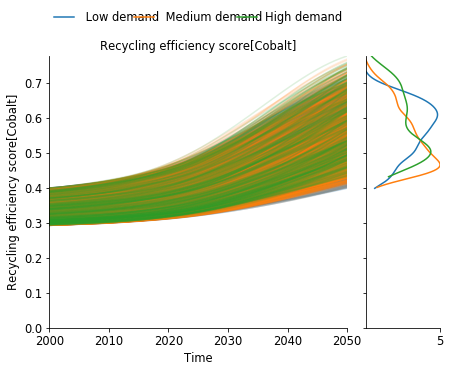

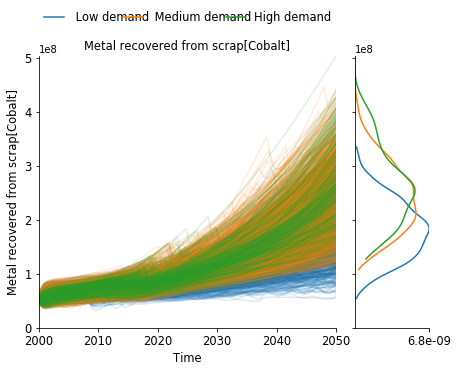

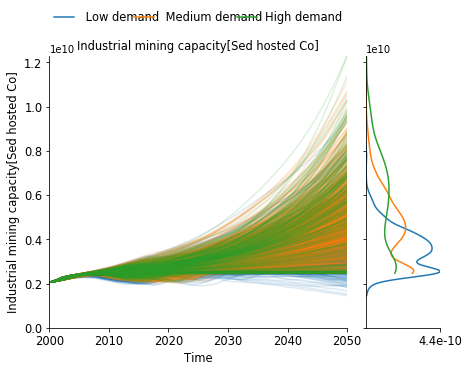

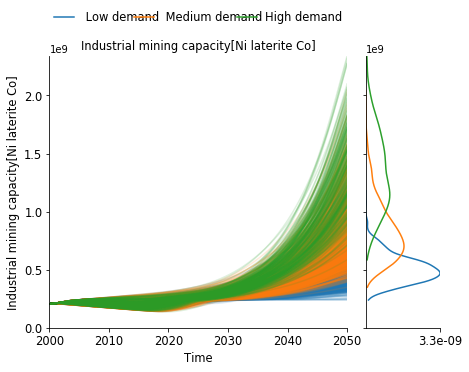

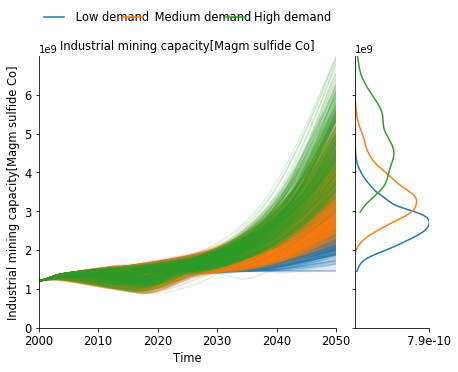

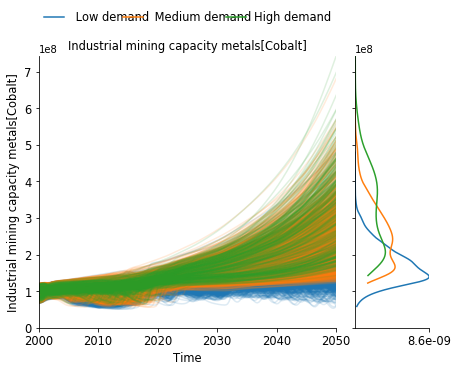

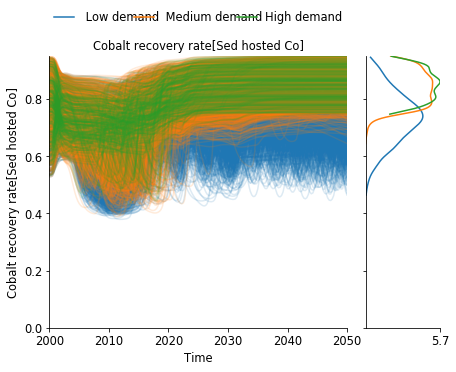

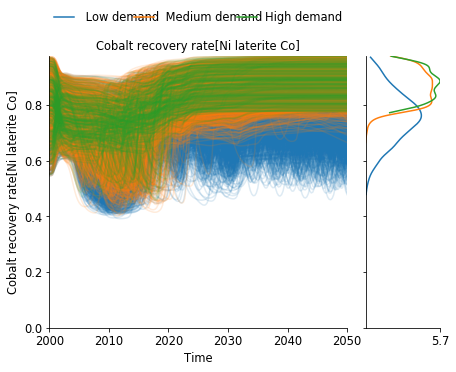

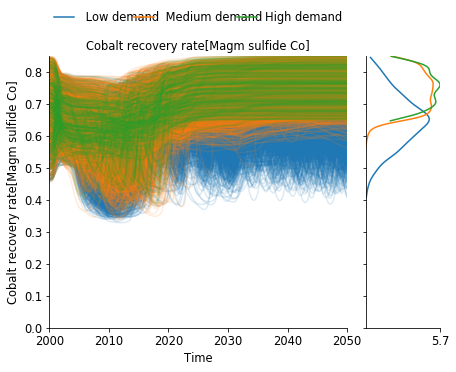

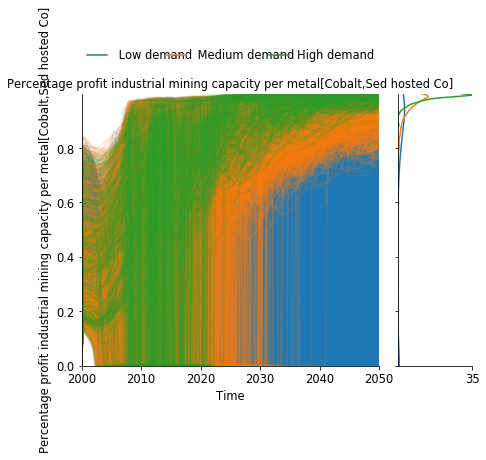

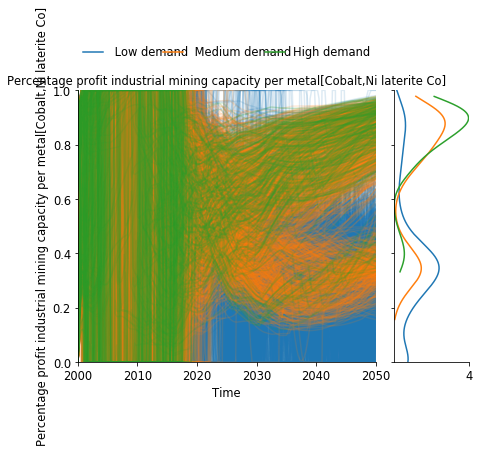

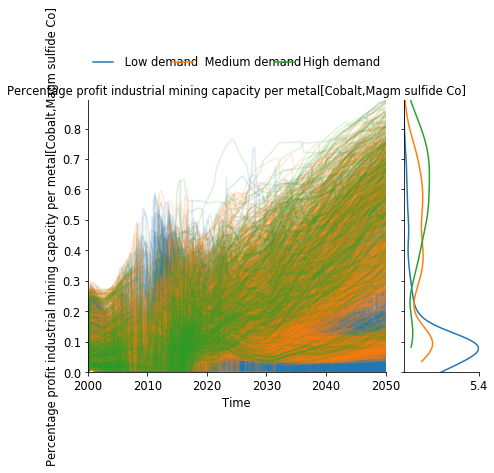

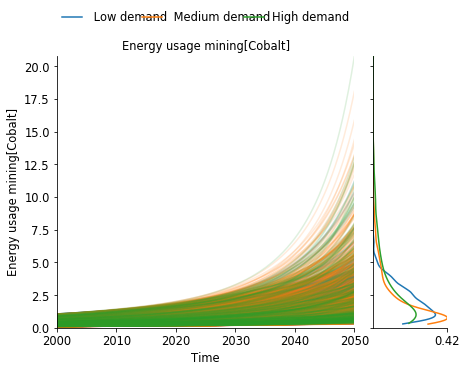

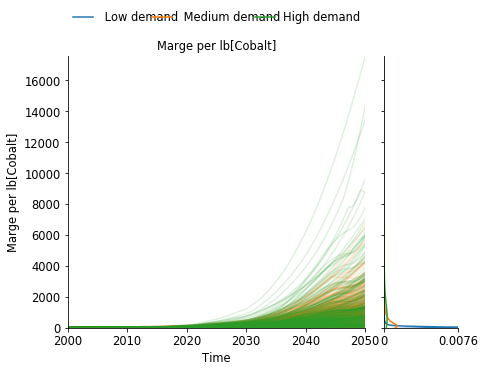

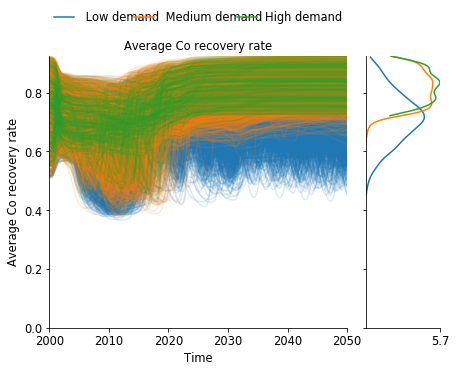

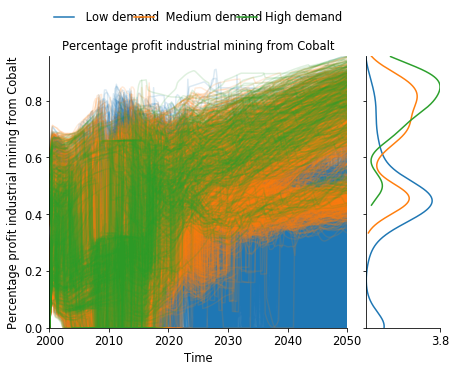

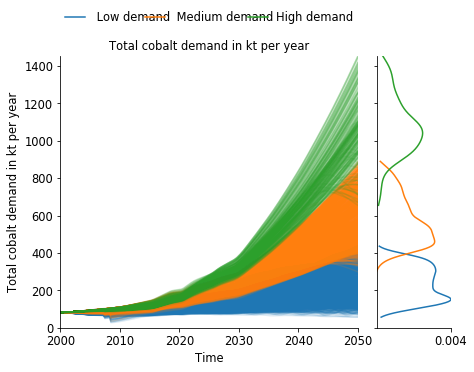

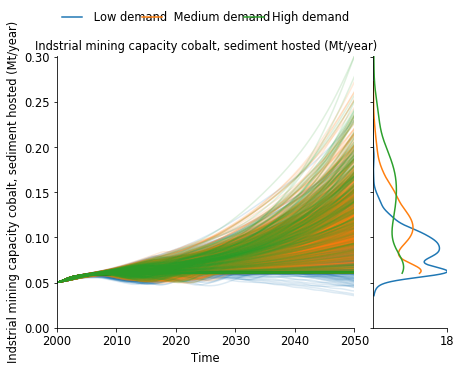

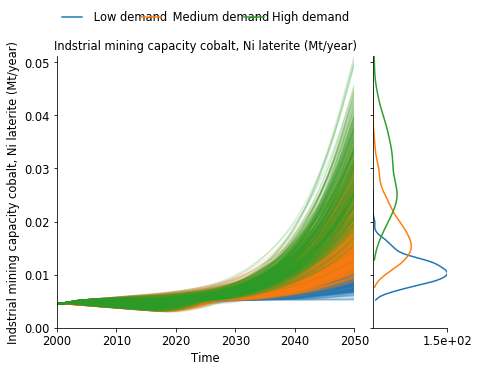

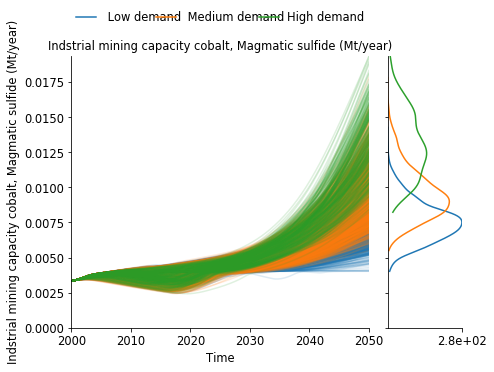

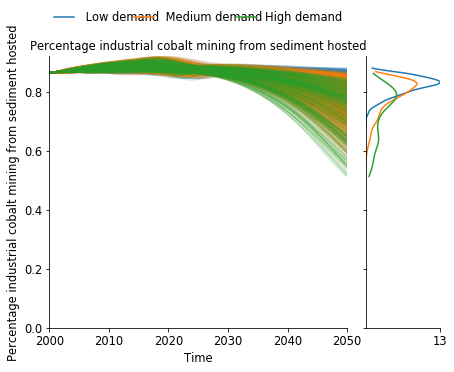

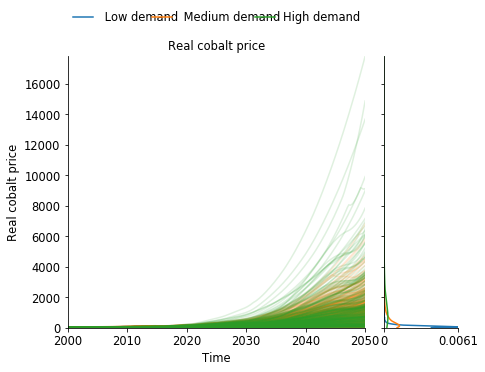

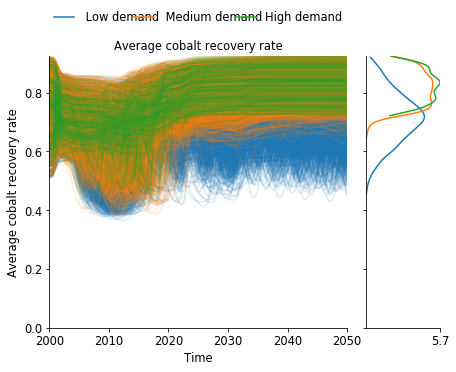

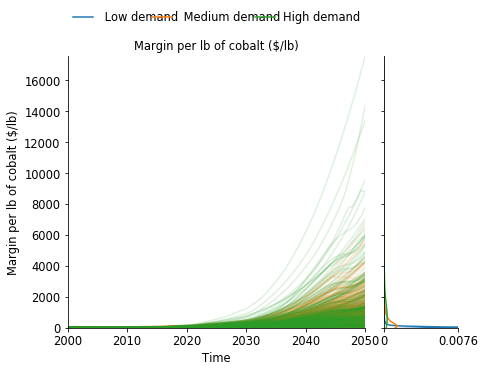

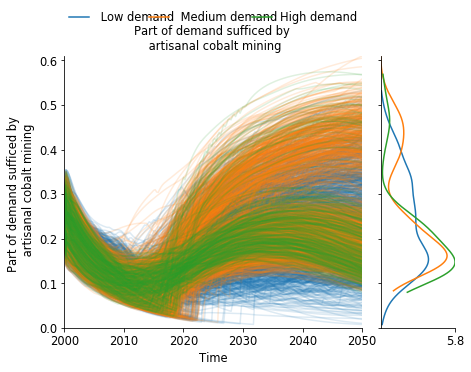

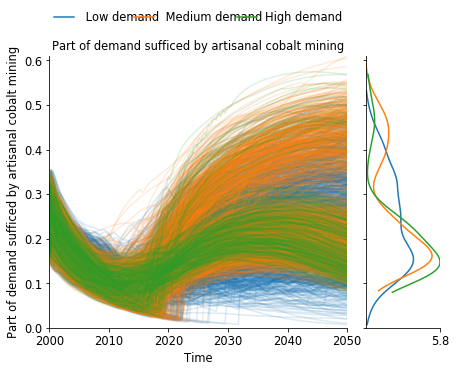

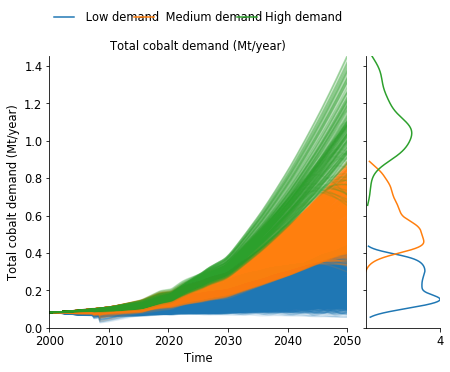

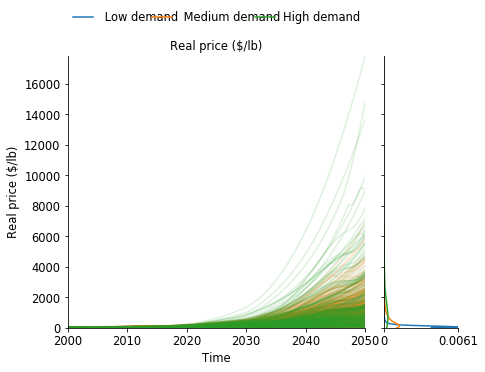

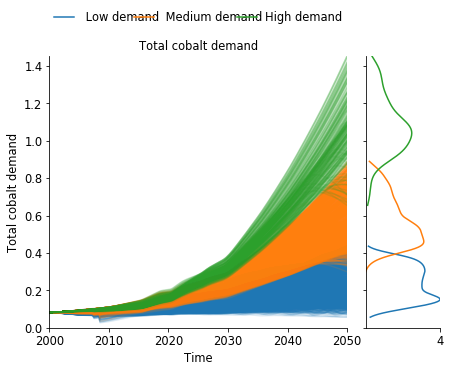

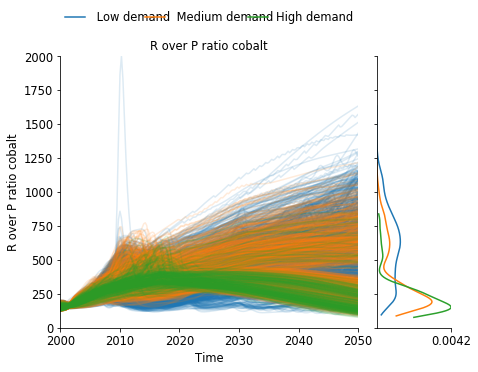

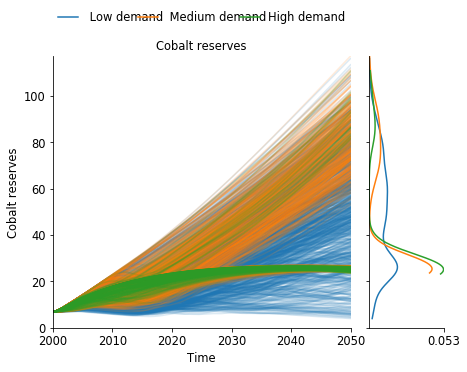

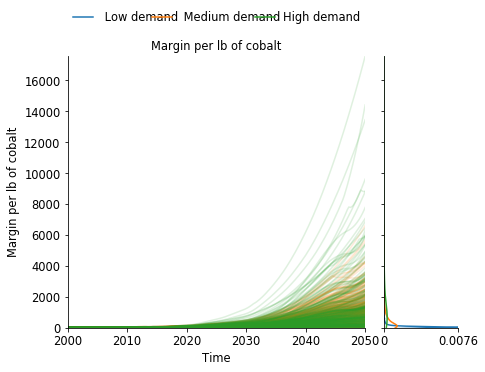

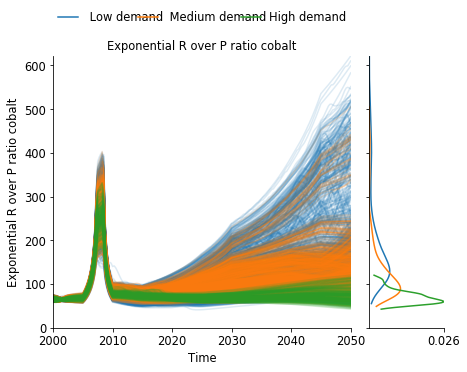

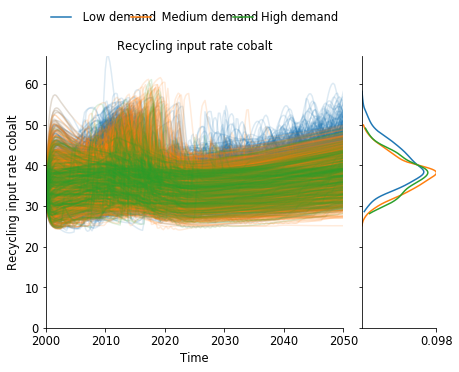

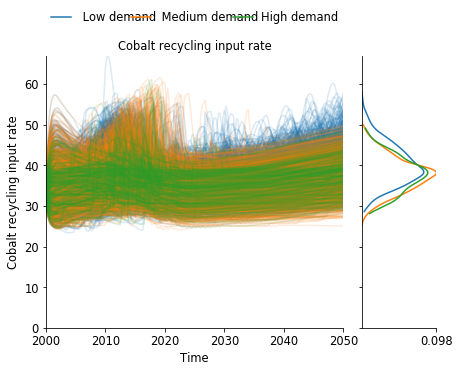

In [641]:
for i in out_b:
    if i != 'TIME':
        if i == 'Normalised profit forecast[Copper]':
            fig,axes=plot_clusters('both', i , clustered_demand, zero= False)
        elif i == 'Normalised profit forecast[Nickel]':
            fig,axes=plot_clusters('both', i , clustered_demand, zero= False)
        elif i == 'Normalised profit forecast[Cobalt]':
            fig,axes=plot_clusters('both', i , clustered_demand, zero= False)
        else:
            fig,axes = plot_clusters('both', i , clustered_demand, zero= True )
        plt.show()